# Voltaje — Market Basket Analysis para Layout de Depósito (2025)

## Objetivo

Este notebook implementa un enfoque **data-driven** para proponer un **layout de depósito** (ubicación física de productos) basado en el **comportamiento real de compra**.

A partir de transacciones (cestas de compra), vamos a:

- Reducir recorridos dentro del depósito
- Optimizar picking y reposición
- Agrupar productos según afinidad real (co-ocurrencia)

## Fuente de datos

Los datos se leen desde PostgreSQL (Docker) con parámetros **hardcodeados**:

- Host: `localhost`
- Port: `5433`
- Database: `dw`
- User: `dw_user`
- Password: `dw_pwd`

Tabla:

- `datamining.transaction_items_datamining`

## Resultado final

- Comparación de **Apriori**, **FP-Growth** y **Eclat** con métricas claras
- Selección del algoritmo más adecuado para este caso
- **Salidas accionables** para layout:
  - Zonas recomendadas (agrupaciones)
  - Tabla final de coincidencias (producto A/B + support/confidence/lift)
  - Traducción a decisiones físicas de ubicación


In [3]:
# Imports y configuración base

import time
from dataclasses import dataclass
from itertools import combinations
from math import ceil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

import networkx as nx

pd.set_option("display.max_colwidth", 150)
pd.set_option("display.max_columns", 50)

sns.set_theme(style="whitegrid")

@dataclass
class AlgoResult:
    name: str
    frequent_itemsets: pd.DataFrame
    rules: pd.DataFrame
    runtime_sec: float


def _now() -> float:
    return time.perf_counter()


## 1) Conexión a PostgreSQL y extracción de datos

Este paso usa:

- `sqlalchemy` para crear el engine
- `pandas.read_sql` para traer datos

> Nota: en un trabajo académico, esto garantiza reproducibilidad y trazabilidad del dataset usado en el análisis.


In [4]:
# Parámetros de conexión (hardcodeados por requerimiento)
host = "localhost"
port = 5433
database = "dw"
user = "dw_user"
password = "dw_pwd"

engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")

# Consulta: tabla principal de datamining
query = """
SELECT
  transaction_item_id,
  transaction_id,
  product_id,
  product_name,
  product_category,
  product_type,
  quantity,
  transaction_date
FROM datamining.transaction_items_datamining
WHERE quantity > 0
"""

# Lectura desde PostgreSQL
# (si tu contenedor no está levantado, esta celda fallará: levantalo y re-ejecutá)
df = pd.read_sql(query, engine)

df.head()

,transaction_item_id,transaction_id,product_id,product_name,product_category,product_type,quantity,transaction_date
0,495ef9a34cfcef564ccba8def4b54f69,1,329,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,Apliques pared,Iluminación,14,2025-01-01
1,bcb29daf0dddfb5c7f3e24a02c201f74,1,1785,FAROLA LED IP65 50W LC FPO-50W-WW - MACROLED,Iluminación exterior,Iluminación,11,2025-01-01
2,abb4970974cce4714017223fed104e96,1,1953,GABINETE IP67 15X15X10 TRANSPARENTE ZG 1515 TR - CABRERA,Gabinetes eléctricos,Materiales eléctricos,14,2025-01-01
3,094e479abf0ca6fdbf51bf91c6c2be47,1,2227,LAMP. FILAMENTO LED BULBO 8W LC,LED,Iluminación,8,2025-01-01
4,dfcb13319c8235d1dec42d388eb80dd0,2,22,**APLIQUE PARED P/E27 2L C/TULIPA BASE OVAL ACE 18022 - SJT,Apliques pared,Iluminación,9,2025-01-01


## 2) EDA mínimo (sanity checks)

Antes de minería de reglas, verificamos:

- Cantidad total de transacciones
- Cantidad de productos únicos
- Top productos más vendidos
- Tamaño promedio de las cestas
- Distribución de ítems por transacción


Filas (items): 365,561
Transacciones únicas (baskets): 81,215
Productos únicos (por product_name): 3,954


,product_name,quantity
317,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,348198
3266,RODA - LLAVE COMPLETA COMBINADA BL - SCHNEIDER,206570
3718,TORNILLO PTA AGUJA FOSF NEGRO P/GRUESO 6 X 2` X UD-,142717
1938,GABINETE IP67 15X15X10 TRANSPARENTE ZG 1515 TR - CABRERA,106890
2718,PANEL LED CIRCULAR 18W LF - ECO,83129
764,CABLE SUBTERRANEO AL 3X240+120 MM C/ NORMAS IRAM,70096
3309,RUMA APLIQUE PARED P/DICRO 1L BL RU-L1 - VGL,58962
1135,CAPACITOR 25 MF 450V MONOFASICO CORILUX CCT018,51716
3564,TECLA SMART 2 CANALES AC110-240V MAX 10A BL TSX2B - MACROLED,43732
948,CABLE VAINA REDONDO BLANCO 2X0.50MM - LUMIPACK,39581


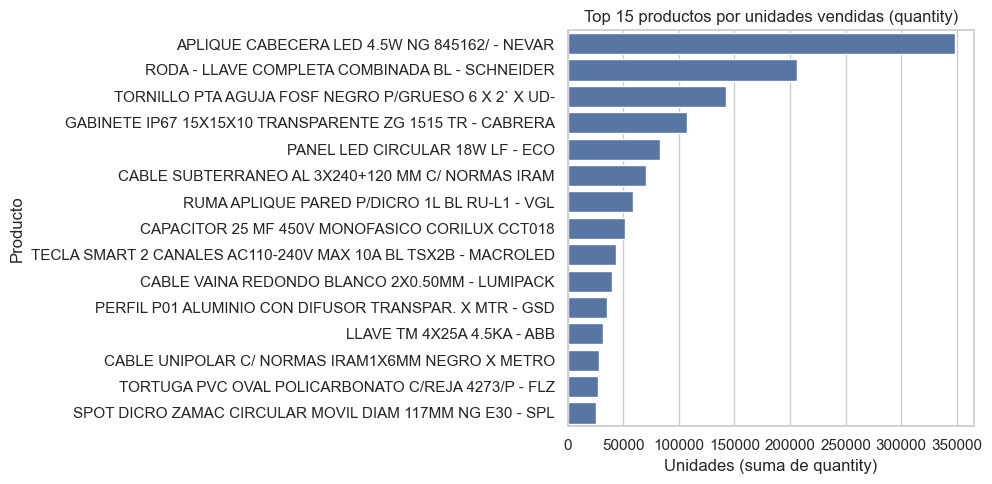

Tamaño promedio de cesta (productos distintos): 4.50
Mediana tamaño de cesta: 5


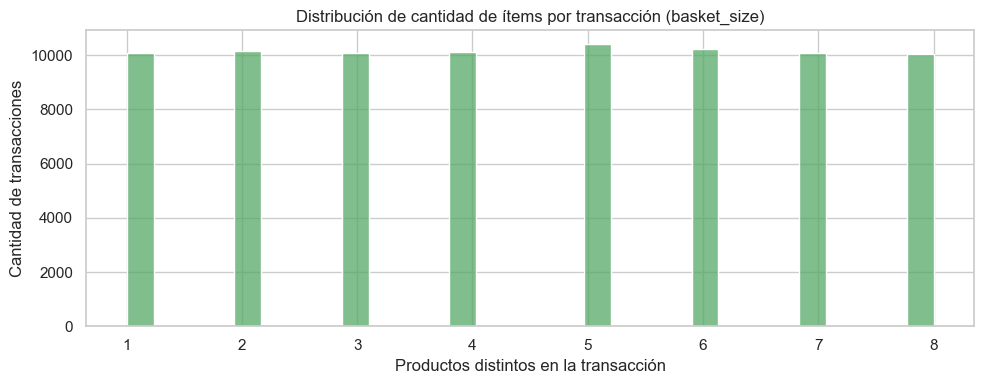

In [5]:
# Limpieza mínima de columnas clave
_df = df.copy()
_df["product_name"] = _df["product_name"].astype(str).str.strip()
_df = _df[_df["product_name"].ne("")]

n_rows = len(_df)
n_transactions = _df["transaction_id"].nunique()
n_products = _df["product_name"].nunique()

print(f"Filas (items): {n_rows:,}")
print(f"Transacciones únicas (baskets): {n_transactions:,}")
print(f"Productos únicos (por product_name): {n_products:,}")

# Top productos por unidades vendidas (usa quantity)
top_products = (
    _df.groupby("product_name", as_index=False)["quantity"].sum()
    .sort_values("quantity", ascending=False)
    .head(15)
)

display(top_products)

plt.figure(figsize=(10, 5))
sns.barplot(data=top_products, y="product_name", x="quantity", color="#4C72B0")
plt.title("Top 15 productos por unidades vendidas (quantity)")
plt.xlabel("Unidades (suma de quantity)")
plt.ylabel("Producto")
plt.tight_layout()
plt.show()

# Tamaño de cesta: cantidad de productos distintos por transacción
basket_sizes = (
    _df.groupby("transaction_id")["product_name"]
    .nunique()
    .rename("basket_size")
)

print(f"Tamaño promedio de cesta (productos distintos): {basket_sizes.mean():.2f}")
print(f"Mediana tamaño de cesta: {basket_sizes.median():.0f}")

plt.figure(figsize=(10, 4))
sns.histplot(basket_sizes, bins=30, kde=False, color="#55A868")
plt.title("Distribución de cantidad de ítems por transacción (basket_size)")
plt.xlabel("Productos distintos en la transacción")
plt.ylabel("Cantidad de transacciones")
plt.tight_layout()
plt.show()

## EDA ampliado — Concentración y co-ocurrencia (diagnóstico visual)

Antes de aplicar algoritmos, conviene ver **si hay concentración** (pocos productos explican gran parte de las ventas) y si existen **co-ocurrencias repetidas** entre los productos más relevantes.

Estos gráficos ayudan a responder:

- ¿Hay una “regla 80/20” (pocos productos dominan)?
- ¿La demanda es pareja o hay mucha dispersión?
- ¿Entre los productos más vendidos se observan relaciones claras?


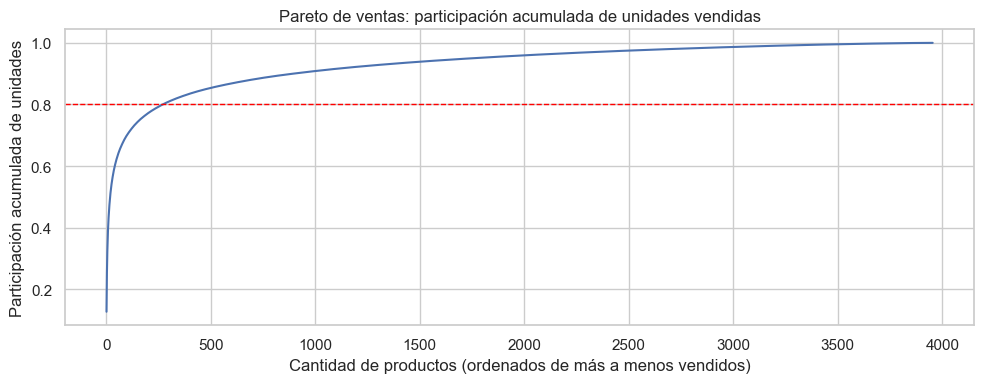

Productos necesarios para explicar ~80% de unidades: 1,252 de 3,954


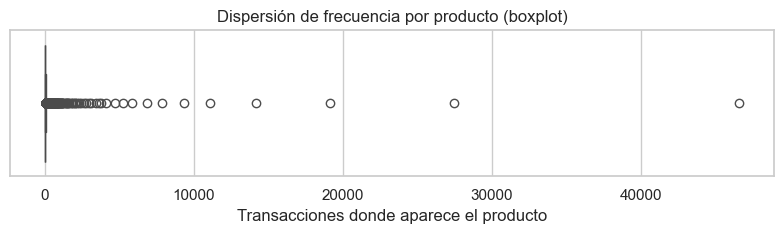

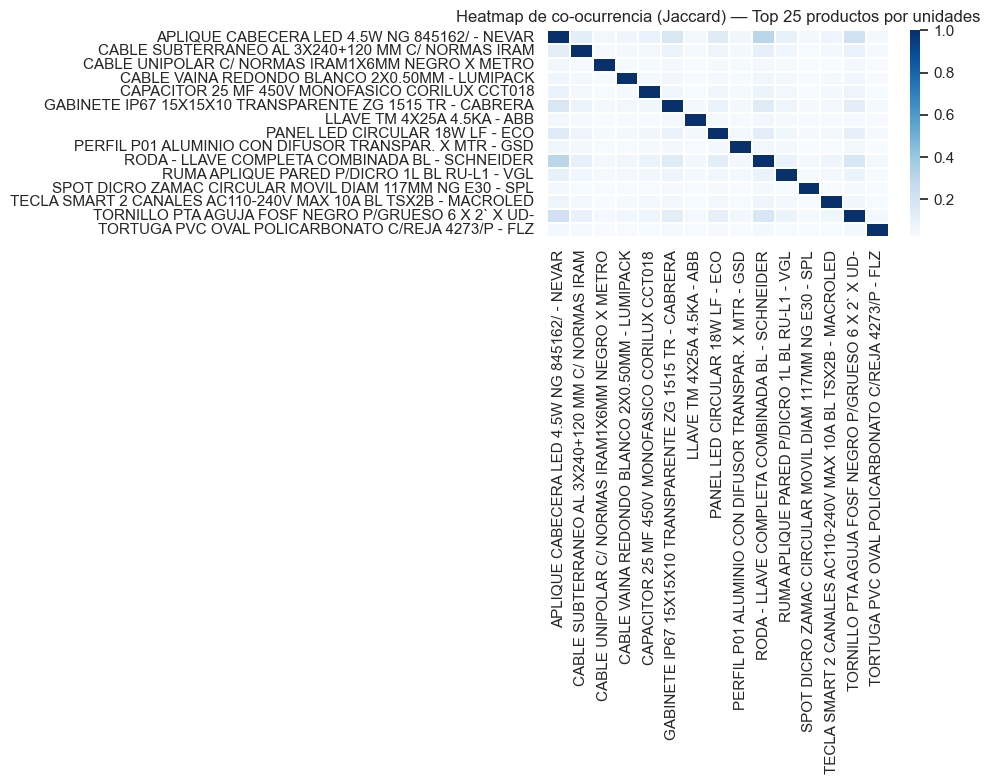

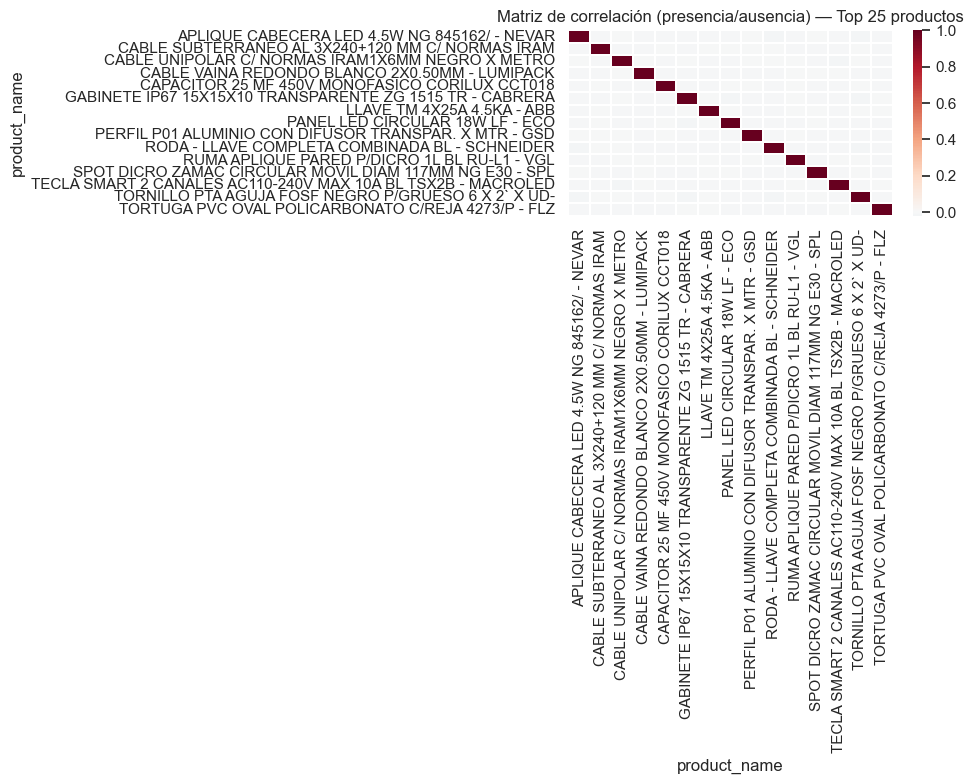

Interpretación: el heatmap Jaccard muestra co-ocurrencia relativa; la correlación resume si tienden a aparecer juntos (valores positivos) o no. Si se ven bloques, suele haber patrones explotables.


In [6]:
# 1) Curva de frecuencia acumulada (Pareto) — unidades vendidas

sales_by_product = (
    _df.groupby("product_name", as_index=False)["quantity"].sum()
    .rename(columns={"quantity": "units_sold"})
    .sort_values("units_sold", ascending=False)
)

sales_by_product["cum_units"] = sales_by_product["units_sold"].cumsum()
sales_by_product["cum_share"] = sales_by_product["cum_units"] / sales_by_product["units_sold"].sum()

plt.figure(figsize=(10, 4))
plt.plot(np.arange(1, len(sales_by_product) + 1), sales_by_product["cum_share"], color="#4C72B0")
plt.axhline(0.8, color="red", linestyle="--", linewidth=1)
plt.title("Pareto de ventas: participación acumulada de unidades vendidas")
plt.xlabel("Cantidad de productos (ordenados de más a menos vendidos)")
plt.ylabel("Participación acumulada de unidades")
plt.tight_layout()
plt.show()

# ¿Cuántos productos explican el 80%?
idx_80 = int((sales_by_product["cum_share"] >= 0.8).idxmax())
print(f"Productos necesarios para explicar ~80% de unidades: {idx_80 + 1:,} de {len(sales_by_product):,}")

# 2) Boxplot de frecuencia de productos (dispersión y outliers)
prod_freq = _df.groupby("product_name")["transaction_id"].nunique().rename("tx_frequency")

plt.figure(figsize=(8, 2.5))
sns.boxplot(x=prod_freq.values, color="#55A868")
plt.title("Dispersión de frecuencia por producto (boxplot)")
plt.xlabel("Transacciones donde aparece el producto")
plt.tight_layout()
plt.show()

# 3) Co-ocurrencia entre productos top (presencia/ausencia)
TOP_N = 25

topN_names = top_products["product_name"].head(TOP_N).tolist()

_df_top = _df[_df["product_name"].isin(topN_names)][["transaction_id", "product_name"]].drop_duplicates()

# Matriz transacción x producto (0/1) para top N
X_top = pd.crosstab(_df_top["transaction_id"], _df_top["product_name"]).astype(int)

# Co-ocurrencia por conteo: cuántas transacciones contienen ambos
cooc_counts = X_top.T.dot(X_top)

# Jaccard: intersección / unión (más interpretable que conteo en algunos casos)
diag = np.diag(cooc_counts)
union = diag[:, None] + diag[None, :] - cooc_counts.values
jaccard = np.divide(cooc_counts.values, union, out=np.zeros_like(cooc_counts.values, dtype=float), where=union != 0)

plt.figure(figsize=(10, 8))
sns.heatmap(
    jaccard,
    xticklabels=cooc_counts.columns,
    yticklabels=cooc_counts.index,
    cmap="Blues",
    linewidths=0.2,
)
plt.title(f"Heatmap de co-ocurrencia (Jaccard) — Top {TOP_N} productos por unidades")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Matriz de correlación (presencia/ausencia) entre productos top
# Esto ayuda a ver asociaciones positivas/negativas de forma rápida.

corr = X_top.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    cmap="RdBu_r",
    center=0,
    xticklabels=corr.columns,
    yticklabels=corr.index,
    linewidths=0.2,
)
plt.title(f"Matriz de correlación (presencia/ausencia) — Top {TOP_N} productos")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Interpretación breve
print(
    "Interpretación: el heatmap Jaccard muestra co-ocurrencia relativa; la correlación resume si tienden a aparecer juntos "
    "(valores positivos) o no. Si se ven bloques, suele haber patrones explotables."
)

## Preparación de cestas de compra (Market Basket)

### ¿Qué es una “cesta”?

En Market Basket Analysis, una **cesta (basket)** representa el conjunto de productos que una persona compró **en una misma compra**. La idea es estudiar **co-ocurrencias**: qué productos aparecen juntos con frecuencia.

### ¿Por qué `transaction_id` define una cesta?

En esta tabla, cada fila representa un ítem vendido y cada `transaction_id` identifica la venta completa. Por lo tanto:

- **Una transacción** = una **cesta**
- **Varias filas con el mismo `transaction_id`** = productos comprados juntos

### ¿Por qué usamos presencia/ausencia de `product_name`?

Para reglas clásicas de asociación (Apriori / FP-Growth / Eclat), lo más común es modelar **si el producto aparece o no** en la cesta:

- 1 = el producto estuvo en la compra
- 0 = el producto no estuvo

Esto facilita interpretar reglas como:

> “Si el cliente compra *A*, también suele comprar *B*.”

### ¿Por qué ignoramos `quantity` al inicio?

`quantity` indica cuántas unidades se vendieron, pero las reglas clásicas buscan relaciones de **co-ocurrencia** (presencia) más que de volumen. Incorporar cantidades requiere variantes (por ejemplo, reglas ponderadas o discretización), lo cual puede complicar interpretación.

**Decisión metodológica**: en esta primera etapa usamos presencia/ausencia para obtener reglas claras y accionables para layout. Más adelante, `quantity` puede reintroducirse para priorizar reubicaciones por impacto de volumen.


In [7]:
# 1) Construcción de cestas: transaction_id -> lista de product_name
# - Usamos product_name como ítem principal (requerimiento)
# - Convertimos cada transacción a un conjunto (set) para quedarnos con presencia/ausencia

baskets_raw = (
    _df.groupby("transaction_id")["product_name"]
    .apply(lambda s: sorted(set(s)))
)

# Eliminamos transacciones vacías (no deberían existir) y, si corresponde, las de 1 solo ítem.
# Justificación: reglas de asociación requieren co-ocurrencia; con 1 ítem no se pueden formar pares ni reglas útiles.
baskets = baskets_raw[baskets_raw.apply(len) >= 2]

print(f"Cestas totales (>=2 ítems): {len(baskets):,} (de {baskets_raw.shape[0]:,} transacciones)")
print(f"Tamaño promedio de cesta (>=2 ítems): {baskets.apply(len).mean():.2f}")

# Mostrar 5 cestas reales (legible)
sample_baskets = baskets.sample(5, random_state=42)
for tid, items in sample_baskets.items():
    print(f"\ntransaction_id={tid}  (n_items={len(items)})")
    print("- " + "\n- ".join(items[:30]) + ("\n- ..." if len(items) > 30 else ""))

Cestas totales (>=2 ítems): 71,120 (de 81,215 transacciones)
Tamaño promedio de cesta (>=2 ítems): 5.00

transaction_id=65009  (n_items=3)
- ACCESORIOS PLAFON 60X60CM- ILUMA
- CABLE UNIPOLAR C/ NORMAS IRAM1X6MM NEGRO KALOP
- GABINETE IP67 15X15X10 TRANSPARENTE ZG 1515 TR - CABRERA

transaction_id=5800  (n_items=5)
- **APLIQUE PARED JAULA MINI DIAMANTE NG CJ6540 - SAN JUSTO
- **GRAMPA CHAVETA 7/8 - DAISA 8138003
- BASE TOMA IND 2X16A C/ TIERRA 252 - MIG
- CAJA PARA TERMICA CON TAPA 2 MOD. GRIS - KL02472T - KALOP
- RODA - LLAVE COMPLETA COMBINADA BL - SCHNEIDER

transaction_id=6237  (n_items=4)
- APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR
- CABEZAL FOCAL NG P/ RIEL MAG 330MM MACROLED
- DICROICA LED 6W - GU10 LF
- RELES DE SOBRECARGA TM 25M REGULACION 17 - 25A - CHINT

transaction_id=58356  (n_items=7)
- **TABLERO PVC EMBUTIR Q ENERGY 36 POLOS 480036 - GENROD
- CABLE VAINA REDONDO BLANCO 2X0.50MM - LUMIPACK
- LLAVE TM 3X20 A 6KA - CHINT
- PANEL LED 30X120 - 40W LN - MACROLED
- RODA - LL

## Gráficos sobre cestas de compra (diagnóstico)

Estas visualizaciones ayudan a entender si las compras son “densas” (muchos ítems por transacción) o “dispersas” (pocos ítems), y también si existen pares repetidos con suficiente frecuencia como para ser útiles en layout.


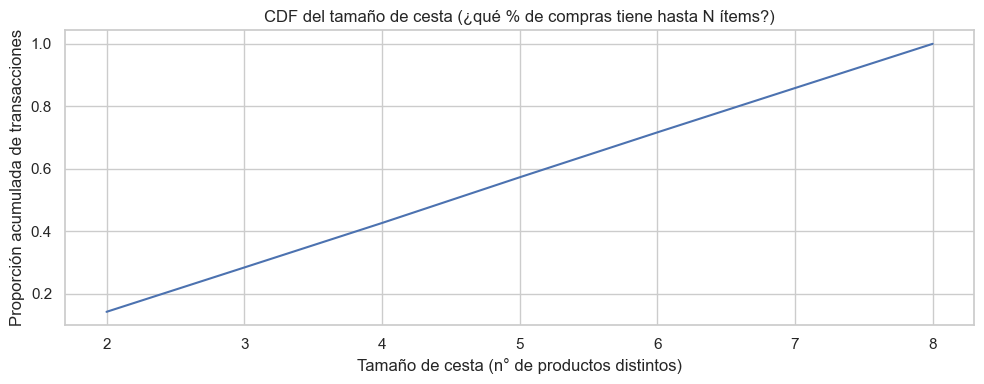

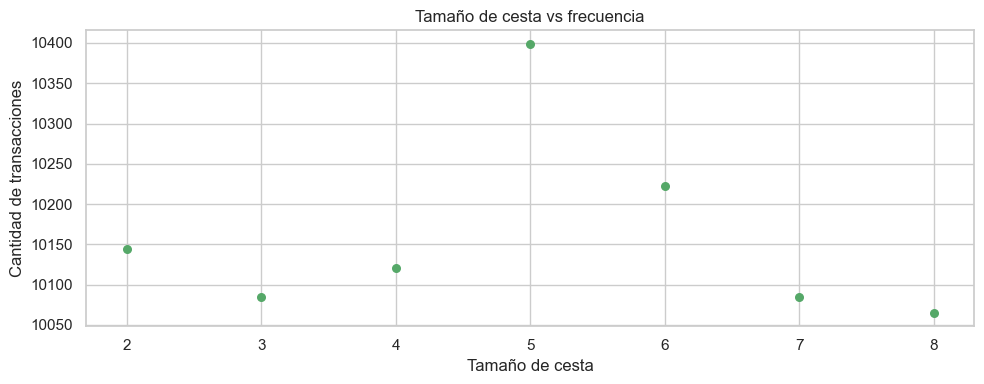

Interpretación: si la mayoría de compras tiene pocos ítems, los patrones suelen ser más escasos y hay que ajustar soporte.


C:\Users\Usuario\AppData\Local\Temp\ipykernel_32876\70029774.py:55: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


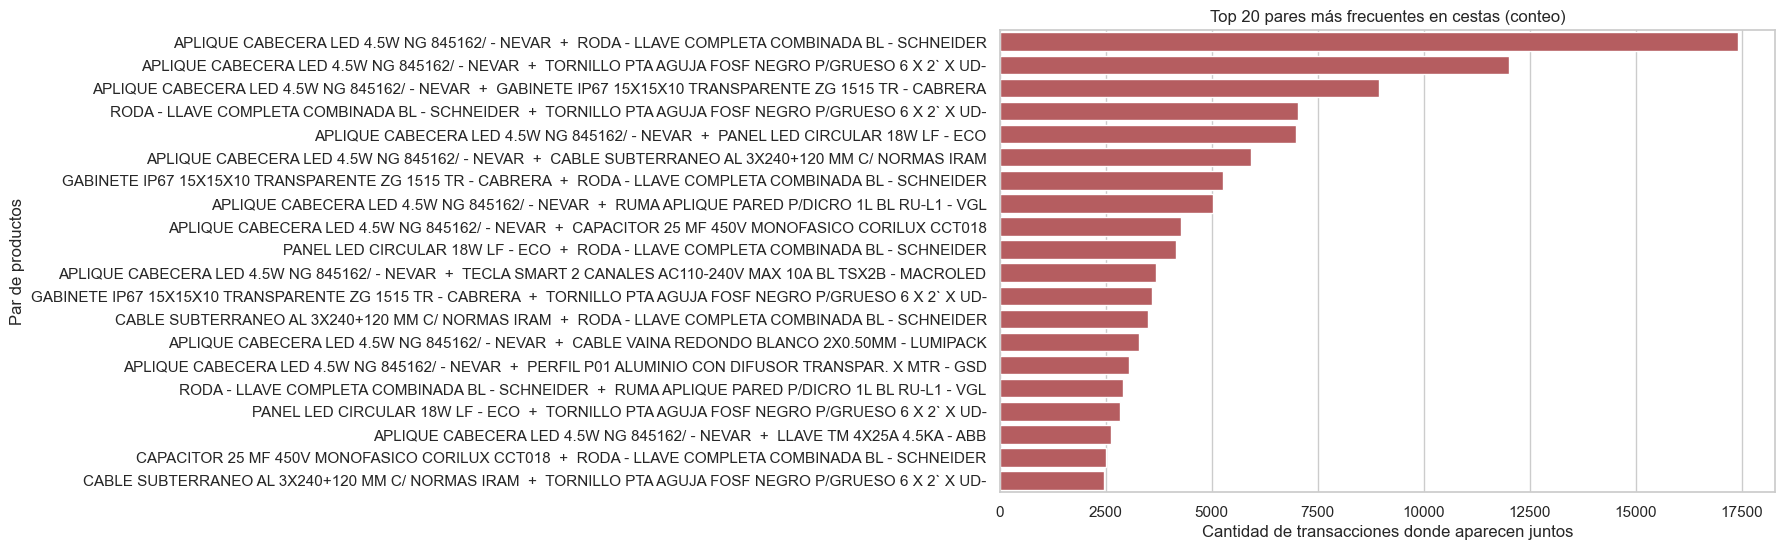

In [8]:
# Distribución acumulada del tamaño de cesta (CDF)

basket_sizes_b = baskets.apply(len)

cdf = basket_sizes_b.value_counts().sort_index().cumsum() / len(basket_sizes_b)

plt.figure(figsize=(10, 4))
plt.plot(cdf.index, cdf.values, color="#4C72B0")
plt.title("CDF del tamaño de cesta (¿qué % de compras tiene hasta N ítems?)")
plt.xlabel("Tamaño de cesta (n° de productos distintos)")
plt.ylabel("Proporción acumulada de transacciones")
plt.tight_layout()
plt.show()

# Relación tamaño de cesta vs frecuencia (cuántas compras tienen ese tamaño)
size_counts = basket_sizes_b.value_counts().sort_index()

plt.figure(figsize=(10, 4))
plt.scatter(size_counts.index, size_counts.values, s=30, color="#55A868")
plt.title("Tamaño de cesta vs frecuencia")
plt.xlabel("Tamaño de cesta")
plt.ylabel("Cantidad de transacciones")
plt.tight_layout()
plt.show()

print("Interpretación: si la mayoría de compras tiene pocos ítems, los patrones suelen ser más escasos y hay que ajustar soporte.")

# Top pares de productos más frecuentes (por conteo en cestas)
from collections import Counter

pair_counter = Counter()
for items in baskets.tolist():
    # combinaciones de pares dentro de la misma compra
    for a, b in combinations(items, 2):
        pair_counter[(a, b)] += 1

TOP_PAIRS = 20
top_pairs = pair_counter.most_common(TOP_PAIRS)

pairs_df = pd.DataFrame(
    [
        {"Producto A": a, "Producto B": b, "Cooc (count)": c}
        for (a, b), c in top_pairs
    ]
)

# Barra horizontal para lectura
pairs_df["par"] = pairs_df["Producto A"] + "  +  " + pairs_df["Producto B"]

plt.figure(figsize=(10, 6))
sns.barplot(data=pairs_df, y="par", x="Cooc (count)", color="#C44E52")
plt.title(f"Top {TOP_PAIRS} pares más frecuentes en cestas (conteo)")
plt.xlabel("Cantidad de transacciones donde aparecen juntos")
plt.ylabel("Par de productos")
plt.tight_layout()
plt.show()

### Top 15 productos más frecuentes y su principal co-ocurrencia

Esta tabla resume, para los productos que más aparecen en compras, **con qué otro producto se combinan más seguido**.

- La frecuencia se calcula por **presencia en transacciones** (no por `quantity`).
- La co-ocurrencia es el **conteo de transacciones** donde aparecen juntos.

Es una salida muy práctica para layout porque permite ver rápidamente “parejas típicas” de compra.


In [9]:
# Tabla: Top 15 por frecuencia + principal co-ocurrencia

from collections import Counter, defaultdict

# Frecuencia (presencia) por producto en transacciones
item_freq = baskets.explode().value_counts()
top15_items = item_freq.head(15)

# Co-ocurrencia dirigida: para cada producto, contamos con qué otros aparece
cooc = defaultdict(Counter)

for items in baskets.tolist():
    for a, b in combinations(items, 2):
        cooc[a][b] += 1
        cooc[b][a] += 1

rows = []
for product_name, freq in top15_items.items():
    if len(cooc[product_name]) == 0:
        best_other, best_count = None, 0
    else:
        best_other, best_count = cooc[product_name].most_common(1)[0]

    rows.append(
        {
            "product_name": product_name,
            "frecuencia_transacciones": int(freq),
            "producto_mas_coocurrente": best_other,
            "coocurrencia_con_otro": int(best_count),
        }
    )

summary_top15 = pd.DataFrame(rows).sort_values("frecuencia_transacciones", ascending=False)

display(summary_top15)

print("Nota: 'coocurrencia_con_otro' cuenta transacciones donde aparecen juntos (presencia/ausencia).")

,product_name,frecuencia_transacciones,producto_mas_coocurrente,coocurrencia_con_otro
0,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,44696,RODA - LLAVE COMPLETA COMBINADA BL - SCHNEIDER,17414
1,RODA - LLAVE COMPLETA COMBINADA BL - SCHNEIDER,26569,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,17414
2,TORNILLO PTA AGUJA FOSF NEGRO P/GRUESO 6 X 2` X UD-,18592,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,12012
3,GABINETE IP67 15X15X10 TRANSPARENTE ZG 1515 TR - CABRERA,13760,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,8955
4,PANEL LED CIRCULAR 18W LF - ECO,10786,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,6995
5,CABLE SUBTERRANEO AL 3X240+120 MM C/ NORMAS IRAM,9093,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,5928
6,RUMA APLIQUE PARED P/DICRO 1L BL RU-L1 - VGL,7697,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,5026
7,CAPACITOR 25 MF 450V MONOFASICO CORILUX CCT018,6684,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,4283
8,TECLA SMART 2 CANALES AC110-240V MAX 10A BL TSX2B - MACROLED,5670,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,3686
9,CABLE VAINA REDONDO BLANCO 2X0.50MM - LUMIPACK,5101,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,3277


Nota: 'coocurrencia_con_otro' cuenta transacciones donde aparecen juntos (presencia/ausencia).


## 2) Transformaciones para algoritmos

### 2.1 One-Hot Encoding (Apriori y FP-Growth)

Apriori y FP-Growth en `mlxtend` trabajan sobre una matriz del tipo:

- filas = transacciones
- columnas = productos
- valor = 1 si el producto aparece en la transacción, 0 si no

Como el espacio de productos puede ser grande, conviene:

- definir un `min_support`
- **filtrar productos demasiado raros** (que nunca podrían ser frecuentes con ese soporte)

Esto mejora performance sin “perder” reglas, porque por definición un ítem con soporte menor al umbral no puede formar itemsets frecuentes.

### 2.2 Formato vertical (Eclat)

Eclat suele implementarse en **formato vertical**, donde cada producto se representa como el conjunto de transacciones en las que aparece:

- `item -> {transaction_id_1, transaction_id_2, ...}`

Luego, los itemsets se obtienen por intersección de conjuntos (tidsets).

In [10]:
# Elegimos umbrales (se usan iguales en los 3 algoritmos para comparación justa)
# - min_support: porcentaje mínimo de transacciones donde debe aparecer un itemset
# - min_confidence: fuerza mínima de la regla A -> B
#
# Importante: si el negocio vende muchos productos distintos y “largas colas” (mucha variedad),
# es normal que los pares de productos se repitan pocas veces. En ese caso, un soporte muy alto
# deja el análisis sin reglas. Por eso usamos un soporte mínimo expresado como CONTEO de transacciones.

n_tx = len(baskets)

# Umbral de confianza: qué tan seguido aparece B cuando aparece A
min_confidence = 0.5

# Soporte mínimo como CONTEO de transacciones (ajustable)
# Recomendación práctica: empezar con 20 y luego ajustar según la cantidad de reglas obtenidas.
min_support_count = 80
min_support = min_support_count / n_tx

print(f"Transacciones consideradas: {n_tx:,}")
print(f"min_support_count = {min_support_count:,}  => min_support = {min_support:.6f}")
print(f"min_confidence = {min_confidence:.2f}")

# Soporte univariado (por presencia) para filtrar ítems raros ANTES del one-hot
item_counts = baskets.explode().value_counts()
item_support = (item_counts / n_tx).rename("support")

print(f"Productos en cestas (antes de filtrar por soporte): {item_support.shape[0]:,}")

display(item_support.head(15).to_frame())

items_kept = item_support[item_support >= min_support].index
print(f"Productos con support >= min_support: {len(items_kept):,}")

# Filtramos las cestas para quedarnos solo con ítems potencialmente frecuentes
baskets_filtered = baskets.apply(lambda items: [x for x in items if x in items_kept])

# Luego eliminamos cestas que quedaron con 0 o 1 ítem tras el filtrado
baskets_filtered = baskets_filtered[baskets_filtered.apply(len) >= 2]

print(f"Cestas (>=2 ítems) después de filtrar ítems raros: {len(baskets_filtered):,}")
print(f"Tamaño promedio (post-filtrado): {baskets_filtered.apply(len).mean():.2f}")

if baskets_filtered.empty:
    raise ValueError(
        "Luego del filtrado por soporte no quedaron cestas con >=2 ítems. "
        "Bajá min_support_count (p.ej. 10) o eliminá el filtrado de ítems raros."
    )

Transacciones consideradas: 71,120
min_support_count = 80  => min_support = 0.001125
min_confidence = 0.50
Productos en cestas (antes de filtrar por soporte): 3,953


,support
product_name,
APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.628459
RODA - LLAVE COMPLETA COMBINADA BL - SCHNEIDER,0.373580
TORNILLO PTA AGUJA FOSF NEGRO P/GRUESO 6 X 2` X UD-,0.261417
GABINETE IP67 15X15X10 TRANSPARENTE ZG 1515 TR - CABRERA,0.193476
PANEL LED CIRCULAR 18W LF - ECO,0.151659
CABLE SUBTERRANEO AL 3X240+120 MM C/ NORMAS IRAM,0.127854
RUMA APLIQUE PARED P/DICRO 1L BL RU-L1 - VGL,0.108226
CAPACITOR 25 MF 450V MONOFASICO CORILUX CCT018,0.093982
TECLA SMART 2 CANALES AC110-240V MAX 10A BL TSX2B - MACROLED,0.079724


Productos con support >= min_support: 387
Cestas (>=2 ítems) después de filtrar ítems raros: 67,359
Tamaño promedio (post-filtrado): 4.33


In [11]:
# 2.1 One-Hot Encoding (sparse) para Apriori y FP-Growth

# Guardrail: si no hay cestas, no tiene sentido seguir
if baskets_filtered.empty:
    raise ValueError("baskets_filtered está vacío. Revisá min_support_count/min_support en la celda anterior.")

transactions = baskets_filtered.tolist()

te = TransactionEncoder()
# sparse=True devuelve una matriz dispersa (muchos ceros), más eficiente en memoria
X_sparse = te.fit(transactions).transform(transactions, sparse=True)

# DataFrame sparse (compatible con mlxtend)
df_ohe = pd.DataFrame.sparse.from_spmatrix(X_sparse, columns=te.columns_)

n_rows_ohe, n_cols_ohe = df_ohe.shape
nnz = int(X_sparse.nnz)  # cantidad de 1s
sparsity = 1 - (nnz / (n_rows_ohe * n_cols_ohe))

print(f"Matriz one-hot: {n_rows_ohe:,} transacciones x {n_cols_ohe:,} productos")
print(f"Densidad (porcentaje de 1s): {(1 - sparsity) * 100:.4f}%")
print(f"Sparsity (porcentaje de 0s): {sparsity * 100:.4f}%")

# Vista rápida
pd.DataFrame({"producto": te.columns_}).head(10)

Matriz one-hot: 67,359 transacciones x 387 productos
Densidad (porcentaje de 1s): 1.1200%
Sparsity (porcentaje de 0s): 98.8800%


C:\Users\Usuario\AppData\Local\Temp\ipykernel_32876\1201652314.py:14: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_ohe = pd.DataFrame.sparse.from_spmatrix(X_sparse, columns=te.columns_)


,producto
0,**APLIQUE PARED P/E27 2L C/TULIPA BASE OVAL ACE 18022 - SJT
1,**AR 111 12W LED - GU10 LC 7308 - CANDELA
2,**BIPIN LED 5W DIMERIZABLE - G9 LC 404106 - INTERELEC
3,**CUBRE BASTIDOR KL40703 - KALOP
4,**DISYUNTOR 4X40 30MA - ABB
5,**FICHA IND 16A HEMBRA 380V 3P+N+T 214-1637 - SCAME
6,**FUSIBLE TIPO NH 80A RT36-1 80A - CHINT
7,**GRAMPA CHAVETA 7/8 - DAISA 8138003
8,**HERRAMIENTA A CRIQUET P/TERM. TUBUL 1 A 10MM2 HS-101 - TBCIN
9,**LAMP. FILAMENTO LED DIM. VELA 5W LC E14


In [12]:
# 2.2 Formato vertical (Eclat): item -> set(transaction_id)
# Construimos tidsets usando las cestas filtradas.

tidsets: dict[str, set[int]] = {}
for tid, items in baskets_filtered.items():
    for item in items:
        tidsets.setdefault(item, set()).add(int(tid))

print(f"Ítems en tidsets: {len(tidsets):,}")

# Ejemplo (3 items) del formato vertical
for item in list(tidsets.keys())[:3]:
    tids = tidsets[item]
    print(f"{item} -> {len(tids):,} transacciones (ej: {list(sorted(tids))[:10]})")

Ítems en tidsets: 387
APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR -> 43,905 transacciones (ej: [1, 2, 3, 6, 11, 12, 13, 15, 17, 18])
FAROLA LED IP65 50W LC FPO-50W-WW - MACROLED -> 571 transacciones (ej: [1, 55, 349, 461, 623, 625, 879, 1106, 1213, 1444])
GABINETE IP67 15X15X10 TRANSPARENTE ZG 1515 TR - CABRERA -> 13,601 transacciones (ej: [1, 3, 23, 55, 59, 62, 67, 71, 74, 75])


## 3) Aplicación de algoritmos

### Definiciones

- **Itemset**: un “combo” de productos (por ejemplo: {cinta aisladora, canaleta PVC}).
- **Itemset frecuente**: un combo que aparece en muchas compras.
- **Regla de asociación**: una frase del tipo: **si compran A, también suelen comprar B**.
  - A se llama **antecedente** y B se llama **consecuente**.

### Métricas

- **Support (soporte)**: qué tan común es el patrón en todas las compras.
  - Ejemplo: support = 0.02 significa “aparece en ~2% de las transacciones”.
- **Confidence (confianza)**: cuando aparece A, con qué frecuencia aparece también B.
  - Ejemplo: confidence = 0.60 significa “en 6 de cada 10 compras con A, también está B”.
- **Lift**: qué tanto mejora la probabilidad de ver B cuando está A, comparado contra “lo normal”.
  - Lift ≈ 1: no hay relación fuerte
  - Lift > 1: relación positiva (útil para poner cerca en el depósito)

> Para el diseño del layout, suelen interesar reglas con **lift alto** y **confidence razonable**, porque sugieren productos que conviene ubicar cerca para reducir recorridos.

### Algoritmos a comparar

En esta sección comparamos tres enfoques para obtener **itemsets frecuentes** y luego **reglas de asociación**:

- **Apriori:** funciona mediante una estrategia de generación y prueba de candidatos. Parte identificando los ítems individuales más frecuentes y luego, en cada iteración, genera combinaciones de ítems más grandes (k-itemsets) a partir de los que ya han sido considerados frecuentes. Cada conjunto candidato es evaluado contra la base de datos completa para calcular su soporte, repitiendo el proceso hasta que no se puedan generar más combinaciones frecuentes.
- **FP-Growth:** elimina la necesidad de generar candidatos de forma explícita. En su lugar, realiza un primer escaneo del dataset para identificar los ítems más frecuentes y luego construye una estructura compacta llamada FP-Tree, que almacena las transacciones en forma comprimida. A partir de este árbol, el algoritmo explora patrones frecuentes de manera recursiva, dividiendo el problema en subconjuntos condicionales sin tener que volver a escanear la base de datos completa.
- **ECLAT:** adopta un enfoque vertical, asociando cada ítem con una lista de transacciones (TID-list) en las que aparece. A partir de estas listas, construye itemsets más grandes mediante la intersección de TID-lists, lo que permite calcular el soporte sin escanear el dataset original.

Para una comparación justa:

- usamos el mismo `min_support` y `min_confidence`
- medimos **tiempo total** (itemsets + reglas)
- calculamos métricas comparables: cantidad de reglas, support/confidence/lift promedio


In [13]:
# Helpers para correr algoritmos y normalizar salidas

n_tx_analysis = df_ohe.shape[0]
min_support_count_analysis = int(ceil(min_support * n_tx_analysis))

print(f"Transacciones efectivas para minería (post-filtrado): {n_tx_analysis:,}")
print(f"min_support_count (sobre transacciones efectivas): {min_support_count_analysis:,}")


def _rules_summary(rules: pd.DataFrame) -> dict:
    if rules is None or rules.empty:
        return {
            "n_rules": 0,
            "avg_support": np.nan,
            "avg_confidence": np.nan,
            "avg_lift": np.nan,
        }
    return {
        "n_rules": int(len(rules)),
        "avg_support": float(rules["support"].mean()),
        "avg_confidence": float(rules["confidence"].mean()),
        "avg_lift": float(rules["lift"].mean()),
    }


def _clean_rules(rules: pd.DataFrame) -> pd.DataFrame:
    if rules is None or rules.empty:
        return pd.DataFrame()

    r = rules.copy()

    # Orden útil para lectura
    cols_first = [
        "antecedents",
        "consequents",
        "support",
        "confidence",
        "lift",
    ]
    cols_first = [c for c in cols_first if c in r.columns]
    r = r[cols_first + [c for c in r.columns if c not in cols_first]]

    # Eliminar reglas degeneradas
    r = r.dropna(subset=["support", "confidence", "lift"], how="any")

    # Orden por impacto típico en MBA
    r = r.sort_values(["lift", "confidence", "support"], ascending=False)
    return r


def _run_mlxtend_algo(name: str, frequent_itemset_func) -> AlgoResult:
    t0 = _now()

    fi = frequent_itemset_func(df_ohe, min_support=min_support, use_colnames=True)

    # association_rules calcula múltiples métricas; usamos confidence como umbral (requerimiento)
    rules = association_rules(fi, metric="confidence", min_threshold=min_confidence)
    rules = _clean_rules(rules)

    runtime = _now() - t0
    print(f"{name}: itemsets={len(fi):,} | rules={len(rules):,} | time={runtime:.2f}s")

    return AlgoResult(name=name, frequent_itemsets=fi, rules=rules, runtime_sec=runtime)


Transacciones efectivas para minería (post-filtrado): 67,359
min_support_count (sobre transacciones efectivas): 76


### 3.1 Apriori

Apriori genera itemsets frecuentes expandiendo combinaciones de productos.

- En **general**, cuando se buscan itemsets más largos (3, 4, 5 productos juntos), Apriori puede volverse **caro** porque explora muchas combinaciones.
- En este notebook, como el objetivo principal de layout es trabajar con **pares (A → B)**, limitamos `max_len=2`. En ese caso, Apriori puede ser **rápido** porque el problema se reduce mucho (básicamente, productos individuales y pares).

Por eso lo usamos como baseline y, si además es el más rápido, es una opción perfectamente válida para este caso.


In [14]:
# Para layout, en general nos alcanza con reglas entre pares (A -> B).
# Limitar a pares evita explosión de combinaciones y hace el resultado más accionable.

apriori_result = _run_mlxtend_algo(
    "Apriori",
    lambda X, **kw: apriori(X, low_memory=True, max_len=2, **kw),
)

# Top reglas (para inspección rápida)
display(apriori_result.rules.head(15))

Apriori: itemsets=1,454 | rules=282 | time=1.16s


,antecedents,consequents,support,confidence,lift,antecedent support,consequent support,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
183,(MEDIA ESFERA COLG 1L P/E27 DIAM 50CM BL 0306/D - FLZ),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001232,0.790476,1.212748,0.001559,0.651806,1.0,0.000216,1.661835,0.175700,0.001889,0.398256,0.396183
127,(ESTAÑO EN CARRETE 500GR 60/40 1MM EST7500 - JA),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001440,0.763780,1.171790,0.001885,0.651806,1.0,0.000211,1.474021,0.146881,0.002208,0.321584,0.382994
84,(CAMBRE SIGLO XXII TAPA 4 MOD-GRIS 14704),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001396,0.758065,1.163022,0.001841,0.651806,1.0,0.000196,1.439202,0.140429,0.002140,0.305170,0.380103
24,(APLIQUE PARED JAULA DIAMANTE BL CJ6691 - SJT),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001173,0.745283,1.143412,0.001574,0.651806,1.0,0.000147,1.366984,0.125623,0.001798,0.268462,0.373541
52,(CABLE PRENSAMBLADO DE COBRE 2X6MM C/ NORMAS IRAM),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001544,0.742857,1.139691,0.002078,0.651806,1.0,0.000189,1.354088,0.122824,0.002367,0.261495,0.372613
167,(LISTON LED BAJO ALACENA 35W LF 120CM 401966 - INTERELEC),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001425,0.732824,1.124298,0.001945,0.651806,1.0,0.000158,1.303240,0.110772,0.002185,0.232682,0.367505
2,(**BIPIN LED 5W DIMERIZABLE - G9 LC 404106 - INTERELEC),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001781,0.727273,1.115781,0.002450,0.651806,1.0,0.000185,1.276711,0.104022,0.002730,0.216738,0.365003
139,(GABINETE AZUL/MARFIL PVC IP65 20X30X15CM - CABRERA),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001485,0.724638,1.111738,0.002049,0.651806,1.0,0.000149,1.264494,0.100714,0.002276,0.209170,0.363458
169,(LLAVE TM 1X20 A SICA DIN SELLO IRAM 6454),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001247,0.724138,1.110972,0.001722,0.651806,1.0,0.000125,1.262203,0.100059,0.001912,0.207735,0.363026
61,(CABLE UNIPOLAR C/ NORMAS IRAM1X1MM MARRON),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001589,0.722973,1.109184,0.002197,0.651806,1.0,0.000156,1.256895,0.098653,0.002435,0.204389,0.362705


### 3.2 FP-Growth

FP-Growth suele ser más eficiente que Apriori cuando buscamos **itemsets más largos** (porque evita generar muchas combinaciones candidatas y usa una estructura compacta para contar patrones).

Sin embargo, si limitamos el análisis a **pares** y tenemos muchas columnas (muchos productos) con matriz muy dispersa, puede pasar que:

- el armado/recorrido de la estructura interna de FP‑Growth tenga más costo fijo, y
- Apriori (con `max_len=2`) termine siendo más directo.

Por eso medimos tiempos reales en este dataset y no asumimos el resultado de antemano.


In [15]:
fpgrowth_result = _run_mlxtend_algo(
    "FP-Growth",
    lambda X, **kw: fpgrowth(X, max_len=2, **kw),
)

display(fpgrowth_result.rules.head(15))

FP-Growth: itemsets=1,454 | rules=282 | time=100.75s


,antecedents,consequents,support,confidence,lift,antecedent support,consequent support,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
269,(MEDIA ESFERA COLG 1L P/E27 DIAM 50CM BL 0306/D - FLZ),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001232,0.790476,1.212748,0.001559,0.651806,1.0,0.000216,1.661835,0.175700,0.001889,0.398256,0.396183
65,(ESTAÑO EN CARRETE 500GR 60/40 1MM EST7500 - JA),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001440,0.763780,1.171790,0.001885,0.651806,1.0,0.000211,1.474021,0.146881,0.002208,0.321584,0.382994
113,(CAMBRE SIGLO XXII TAPA 4 MOD-GRIS 14704),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001396,0.758065,1.163022,0.001841,0.651806,1.0,0.000196,1.439202,0.140429,0.002140,0.305170,0.380103
251,(APLIQUE PARED JAULA DIAMANTE BL CJ6691 - SJT),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001173,0.745283,1.143412,0.001574,0.651806,1.0,0.000147,1.366984,0.125623,0.001798,0.268462,0.373541
125,(CABLE PRENSAMBLADO DE COBRE 2X6MM C/ NORMAS IRAM),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001544,0.742857,1.139691,0.002078,0.651806,1.0,0.000189,1.354088,0.122824,0.002367,0.261495,0.372613
268,(LISTON LED BAJO ALACENA 35W LF 120CM 401966 - INTERELEC),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001425,0.732824,1.124298,0.001945,0.651806,1.0,0.000158,1.303240,0.110772,0.002185,0.232682,0.367505
32,(**BIPIN LED 5W DIMERIZABLE - G9 LC 404106 - INTERELEC),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001781,0.727273,1.115781,0.002450,0.651806,1.0,0.000185,1.276711,0.104022,0.002730,0.216738,0.365003
87,(GABINETE AZUL/MARFIL PVC IP65 20X30X15CM - CABRERA),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001485,0.724638,1.111738,0.002049,0.651806,1.0,0.000149,1.264494,0.100714,0.002276,0.209170,0.363458
213,(LLAVE TM 1X20 A SICA DIN SELLO IRAM 6454),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001247,0.724138,1.110972,0.001722,0.651806,1.0,0.000125,1.262203,0.100059,0.001912,0.207735,0.363026
181,(CABLE UNIPOLAR C/ NORMAS IRAM1X1MM MARRON),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001589,0.722973,1.109184,0.002197,0.651806,1.0,0.000156,1.256895,0.098653,0.002435,0.204389,0.362705


### 3.3 Eclat (enfoque vertical)

En Eclat, en vez de representar cada compra como una fila (formato “horizontal”), representamos cada producto como:

- “lista” de transacciones donde aparece

Luego, para un par de productos (A y B), su co-ocurrencia se obtiene intersectando esas listas.

En este notebook usamos una forma equivalente y eficiente con matriz dispersa:

- `X_sparse.T @ X_sparse` calcula cuántas transacciones comparten cada par de productos.

El resultado es comparable con Apriori/FP-Growth, pero construido desde el enfoque vertical (Eclat).

In [16]:
# Implementación Eclat (pares) usando el enfoque vertical (co-ocurrencia por intersección)

from scipy import sparse


def run_eclat_pairs(X: "sparse.csr_matrix", item_names: list[str], min_count: int, min_conf: float) -> AlgoResult:
    t0 = _now()

    # Nota importante:
    # X suele ser booleana (True/False). Para que X.T @ X devuelva *conteos* (no booleanos),
    # convertimos a entero.
    X_int = X.astype(np.int32)

    n_tx_local = X_int.shape[0]

    # Conteos por ítem (diagonal)
    item_counts_local = np.asarray(X_int.sum(axis=0)).ravel().astype(int)
    item_support_local = item_counts_local / n_tx_local

    # Co-ocurrencias: para cada par (i,j), cuántas transacciones lo contienen
    # Esto es equivalente a intersectar tidsets en Eclat.
    cooc = (X_int.T @ X_int).tocoo()

    # Nos quedamos con triángulo superior sin diagonal (pares i<j)
    mask = (cooc.row < cooc.col) & (cooc.data >= min_count)
    rows = cooc.row[mask]
    cols = cooc.col[mask]
    data = cooc.data[mask].astype(int)

    # Frequent itemsets (pares)
    fi_pairs = pd.DataFrame(
        {
            "support": data / n_tx_local,
            "itemsets": [frozenset((item_names[i], item_names[j])) for i, j in zip(rows, cols)],
            "length": 2,
            "count": data,
        }
    ).sort_values(["support"], ascending=False)

    # Reglas A->B y B->A desde pares
    rules_rows = []
    for i, j, cij in zip(rows, cols, data):
        sup_ab = cij / n_tx_local
        sup_a = item_support_local[i]
        sup_b = item_support_local[j]

        if sup_a > 0:
            conf_a_b = sup_ab / sup_a
            lift_a_b = conf_a_b / sup_b if sup_b > 0 else np.nan
            if conf_a_b >= min_conf:
                rules_rows.append(
                    {
                        "antecedents": frozenset([item_names[i]]),
                        "consequents": frozenset([item_names[j]]),
                        "support": sup_ab,
                        "confidence": conf_a_b,
                        "lift": lift_a_b,
                    }
                )

        if sup_b > 0:
            conf_b_a = sup_ab / sup_b
            lift_b_a = conf_b_a / sup_a if sup_a > 0 else np.nan
            if conf_b_a >= min_conf:
                rules_rows.append(
                    {
                        "antecedents": frozenset([item_names[j]]),
                        "consequents": frozenset([item_names[i]]),
                        "support": sup_ab,
                        "confidence": conf_b_a,
                        "lift": lift_b_a,
                    }
                )

    rules = pd.DataFrame(rules_rows)
    rules = _clean_rules(rules)

    runtime = _now() - t0
    print(f"Eclat (pares): fi_pairs={len(fi_pairs):,} | rules={len(rules):,} | time={runtime:.2f}s")

    return AlgoResult(name="Eclat", frequent_itemsets=fi_pairs, rules=rules, runtime_sec=runtime)


# Ejecutar Eclat sobre la misma matriz usada por Apriori/FP-Growth
# (Importante: para comparación justa, usamos los mismos min_support/min_confidence)
eclat_result = run_eclat_pairs(
    X_sparse.tocsr(),
    list(te.columns_),
    min_count=int(ceil(min_support * df_ohe.shape[0])),
    min_conf=min_confidence,
)

display(eclat_result.rules.head(15))

Eclat (pares): fi_pairs=1,067 | rules=282 | time=0.02s


,antecedents,consequents,support,confidence,lift
183,(MEDIA ESFERA COLG 1L P/E27 DIAM 50CM BL 0306/D - FLZ),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001232,0.790476,1.212748
127,(ESTAÑO EN CARRETE 500GR 60/40 1MM EST7500 - JA),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001440,0.763780,1.171790
84,(CAMBRE SIGLO XXII TAPA 4 MOD-GRIS 14704),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001396,0.758065,1.163022
24,(APLIQUE PARED JAULA DIAMANTE BL CJ6691 - SJT),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001173,0.745283,1.143412
52,(CABLE PRENSAMBLADO DE COBRE 2X6MM C/ NORMAS IRAM),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001544,0.742857,1.139691
167,(LISTON LED BAJO ALACENA 35W LF 120CM 401966 - INTERELEC),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001425,0.732824,1.124298
20,(**BIPIN LED 5W DIMERIZABLE - G9 LC 404106 - INTERELEC),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001781,0.727273,1.115781
139,(GABINETE AZUL/MARFIL PVC IP65 20X30X15CM - CABRERA),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001485,0.724638,1.111738
169,(LLAVE TM 1X20 A SICA DIN SELLO IRAM 6454),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001247,0.724138,1.110972
61,(CABLE UNIPOLAR C/ NORMAS IRAM1X1MM MARRON),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001589,0.722973,1.109184


## 4) Comparación de algoritmos de Market Basket Analysis

En esta comparación buscamos responder una pregunta práctica:

> ¿Qué método nos devuelve **buenas reglas** en un **tiempo razonable**, de manera que podamos convertirlas en decisiones de layout?

No existe “el mejor algoritmo” en abstracto: depende del tamaño del dataset, de cuántos productos hay, y de cuán repetitivos son los patrones.

Por eso comparamos:

- **Cantidad de reglas** (si es 0, el umbral fue muy estricto; si es enorme, puede ser difícil de usar)
- **Promedios de support/confidence/lift** (calidad media de las reglas)
- **Tiempo de ejecución**


In [17]:
results = [apriori_result, fpgrowth_result, eclat_result]

comparison_rows = []
for res in results:
    s = _rules_summary(res.rules)
    comparison_rows.append(
        {
            "Algoritmo": res.name,
            "Cantidad de reglas": s["n_rules"],
            "Support promedio": s["avg_support"],
            "Confidence promedio": s["avg_confidence"],
            "Lift promedio": s["avg_lift"],
            "Tiempo (seg)": res.runtime_sec,
        }
    )

comparison_df = pd.DataFrame(comparison_rows).sort_values(
    ["Cantidad de reglas", "Tiempo (seg)"], ascending=[False, True]
)

display(comparison_df)

# Comentario rápido: si todos dieron 0 reglas, el soporte mínimo sigue demasiado alto.
if comparison_df["Cantidad de reglas"].max() == 0:
    print(
        "No se generaron reglas con los umbrales actuales. "
        "Sugerencia: bajá min_support_count (p.ej. 10) y re-ejecutá desde la celda de umbrales." 
    )

,Algoritmo,Cantidad de reglas,Support promedio,Confidence promedio,Lift promedio,Tiempo (seg)
2,Eclat,282,0.008247,0.661219,1.014442,0.015635
0,Apriori,282,0.008247,0.661219,1.014442,1.161580
1,FP-Growth,282,0.008247,0.661219,1.014442,100.749189


,Algoritmo,support_mean,support_max
0,Apriori,0.008247,0.258525
1,FP-Growth,0.008247,0.258525
2,Eclat,0.008247,0.258525


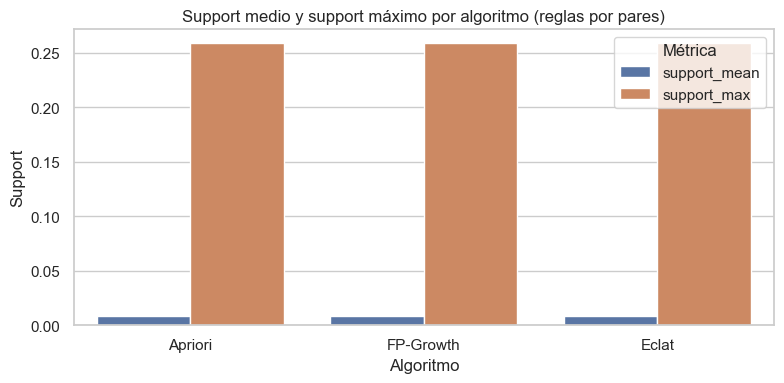

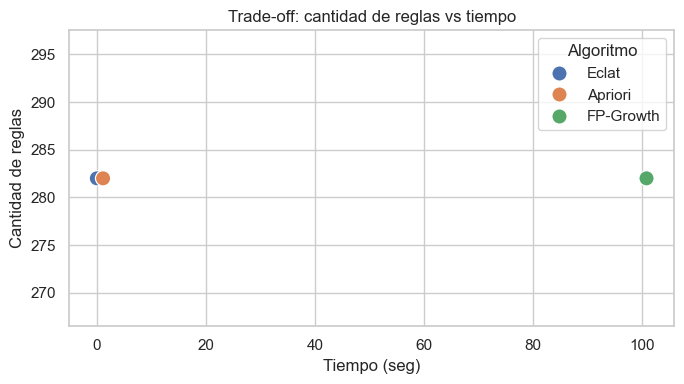

Interpretación: idealmente buscamos muchas reglas útiles con bajo tiempo; si dos algoritmos dan el mismo set, elegimos el más rápido.


In [18]:
# Comparación visual adicional: soporte y trade-off reglas vs tiempo

algo_stats = []
for res in results:
    if res.rules is None or res.rules.empty:
        algo_stats.append({"Algoritmo": res.name, "support_mean": np.nan, "support_max": np.nan})
        continue
    rr = res.rules[
        res.rules["antecedents"].apply(lambda x: len(x) == 1)
        & res.rules["consequents"].apply(lambda x: len(x) == 1)
    ]
    algo_stats.append(
        {
            "Algoritmo": res.name,
            "support_mean": float(rr["support"].mean()),
            "support_max": float(rr["support"].max()),
        }
    )

stats_df = pd.DataFrame(algo_stats)

display(stats_df)

# Support medio vs máximo
melted = stats_df.melt(id_vars=["Algoritmo"], value_vars=["support_mean", "support_max"], var_name="Métrica", value_name="Valor")

plt.figure(figsize=(8, 4))
sns.barplot(data=melted, x="Algoritmo", y="Valor", hue="Métrica")
plt.title("Support medio y support máximo por algoritmo (reglas por pares)")
plt.ylabel("Support")
plt.tight_layout()
plt.show()

# Trade-off: reglas vs tiempo
plt.figure(figsize=(7, 4))
sns.scatterplot(data=comparison_df, x="Tiempo (seg)", y="Cantidad de reglas", hue="Algoritmo", s=120)
plt.title("Trade-off: cantidad de reglas vs tiempo")
plt.xlabel("Tiempo (seg)")
plt.ylabel("Cantidad de reglas")
plt.tight_layout()
plt.show()

print("Interpretación: idealmente buscamos muchas reglas útiles con bajo tiempo; si dos algoritmos dan el mismo set, elegimos el más rápido.")

In [19]:
def _normalize_pair_rules(rules: pd.DataFrame) -> pd.DataFrame:
    if rules is None or rules.empty:
        return pd.DataFrame(columns=["A", "B", "support", "confidence", "lift"])

    r = rules[
        rules["antecedents"].apply(lambda x: len(x) == 1)
        & rules["consequents"].apply(lambda x: len(x) == 1)
    ].copy()

    r["A"] = r["antecedents"].apply(lambda s: next(iter(s)))
    r["B"] = r["consequents"].apply(lambda s: next(iter(s)))

    return r[["A", "B", "support", "confidence", "lift"]].sort_values(["A", "B"]).reset_index(drop=True)


def _pair_rule_key(df: pd.DataFrame) -> set[tuple[str, str]]:
    return set(map(tuple, df[["A", "B"]].to_numpy()))


a_pr = _normalize_pair_rules(apriori_result.rules)
fp_pr = _normalize_pair_rules(fpgrowth_result.rules)
ec_pr = _normalize_pair_rules(eclat_result.rules)

print("Reglas por pares (A→B)")
print(f"- Apriori:   {len(a_pr):,}")
print(f"- FP-Growth: {len(fp_pr):,}")
print(f"- Eclat:     {len(ec_pr):,}")

# Comparar conjuntos de pares (ignorando métricas) para ver si coinciden
ak = _pair_rule_key(a_pr)
fk = _pair_rule_key(fp_pr)
ek = _pair_rule_key(ec_pr)

print("\nCoincidencia de pares (solo A,B):")
print(f"- Apriori vs FP-Growth: {len(ak & fk):,} intersección | {len(ak ^ fk):,} diferencia simétrica")
print(f"- Apriori vs Eclat:     {len(ak & ek):,} intersección | {len(ak ^ ek):,} diferencia simétrica")

# Si hay diferencias, mostramos algunos ejemplos
only_in_apriori = sorted(list(ak - fk))[:10]
only_in_fpgrowth = sorted(list(fk - ak))[:10]

if only_in_apriori or only_in_fpgrowth:
    print("\nEjemplos de diferencias Apriori vs FP-Growth (pares):")
    if only_in_apriori:
        print("- Solo en Apriori:")
        for a, b in only_in_apriori:
            print(f"  {a} -> {b}")
    if only_in_fpgrowth:
        print("- Solo en FP-Growth:")
        for a, b in only_in_fpgrowth:
            print(f"  {a} -> {b}")
else:
    print("\nApriori y FP-Growth devolvieron el MISMO conjunto de reglas por pares (A,B).")

Reglas por pares (A→B)
- Apriori:   282
- FP-Growth: 282
- Eclat:     282

Coincidencia de pares (solo A,B):
- Apriori vs FP-Growth: 282 intersección | 0 diferencia simétrica
- Apriori vs Eclat:     282 intersección | 0 diferencia simétrica

Apriori y FP-Growth devolvieron el MISMO conjunto de reglas por pares (A,B).


## 5) Selección del mejor algoritmo (para decisiones de layout)

Para este caso de uso, lo más importante no es sólo “hacer minería”, sino que el resultado sea **usable** para reorganizar el depósito.

Por eso priorizamos:

- **Reglas suficientes** para tomar decisiones (pero no miles imposibles de revisar)
- **Reglas claras** (idealmente entre productos individuales, A → B)
- **Tiempo razonable** de ejecución para poder iterar con parámetros

En general:

- Si Apriori y FP-Growth producen reglas similares, suele elegirse el **más rápido**.
- Eclat es muy útil cuando queremos enfocarnos en **pares** y co-ocurrencias directas.


In [20]:
# Selección automática simple (orientada a negocio):
# 1) Preferimos algoritmos que generen reglas.
# 2) Entre los que generan reglas, preferimos el menor tiempo.

valid = [r for r in results if r.rules is not None and not r.rules.empty]

if not valid:
    best_result = max(results, key=lambda r: r.runtime_sec)  # placeholder (no debería usarse)
    print(
        "No hay reglas para seleccionar un ganador. "
        "Bajá min_support_count y re-ejecutá desde la celda de umbrales." 
    )
else:
    best_result = sorted(valid, key=lambda r: r.runtime_sec)[0]
    print(f"Algoritmo seleccionado: {best_result.name}")

# Mostrar 10 reglas (pares) más útiles para layout
if best_result.rules is not None and not best_result.rules.empty:
    pair_rules = best_result.rules[
        best_result.rules["antecedents"].apply(lambda x: len(x) == 1)
        & best_result.rules["consequents"].apply(lambda x: len(x) == 1)
    ].copy()

    display(pair_rules.head(10))

Algoritmo seleccionado: Eclat


,antecedents,consequents,support,confidence,lift
183,(MEDIA ESFERA COLG 1L P/E27 DIAM 50CM BL 0306/D - FLZ),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001232,0.790476,1.212748
127,(ESTAÑO EN CARRETE 500GR 60/40 1MM EST7500 - JA),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001440,0.763780,1.171790
84,(CAMBRE SIGLO XXII TAPA 4 MOD-GRIS 14704),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001396,0.758065,1.163022
24,(APLIQUE PARED JAULA DIAMANTE BL CJ6691 - SJT),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001173,0.745283,1.143412
52,(CABLE PRENSAMBLADO DE COBRE 2X6MM C/ NORMAS IRAM),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001544,0.742857,1.139691
167,(LISTON LED BAJO ALACENA 35W LF 120CM 401966 - INTERELEC),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001425,0.732824,1.124298
20,(**BIPIN LED 5W DIMERIZABLE - G9 LC 404106 - INTERELEC),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001781,0.727273,1.115781
139,(GABINETE AZUL/MARFIL PVC IP65 20X30X15CM - CABRERA),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001485,0.724638,1.111738
169,(LLAVE TM 1X20 A SICA DIN SELLO IRAM 6454),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001247,0.724138,1.110972
61,(CABLE UNIPOLAR C/ NORMAS IRAM1X1MM MARRON),(APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR),0.001589,0.722973,1.109184


## 6) Salidas finales para diseño de layout (accionables)

A partir del algoritmo seleccionado, convertimos las reglas a una salida que se pueda usar sin leer código.

La idea es traducir métricas a una recomendación simple:

- **Proximidad Alta**: conviene ubicar juntos o en estanterías contiguas
- **Proximidad Media**: conviene ubicar en la misma zona o pasillo cercano
- **Proximidad Baja**: no requiere cercanía (puede priorizarse por otras razones: rotación, volumen, tamaño, seguridad)

> Importante: estas recomendaciones se basan en compras reales (co-ocurrencia). En la práctica se combinan con restricciones físicas del depósito (peso, fragilidad, normativa, volumen, etc.).

In [21]:
# 6.2 Tabla final de coincidencias (pares) + nivel de proximidad

if best_result.rules is None or best_result.rules.empty:
    raise ValueError("No hay reglas para generar salidas de layout. Bajá min_support_count y re-ejecutá.")

rules_pairs = best_result.rules[
    best_result.rules["antecedents"].apply(lambda x: len(x) == 1)
    & best_result.rules["consequents"].apply(lambda x: len(x) == 1)
].copy()

# Convertir frozenset -> string
rules_pairs["Producto A"] = rules_pairs["antecedents"].apply(lambda s: next(iter(s)))
rules_pairs["Producto B"] = rules_pairs["consequents"].apply(lambda s: next(iter(s)))

# Regla simple de proximidad (ajustable)
# - Alta: lift alto y confianza alta
# - Media: lift moderado o confianza moderada
# - Baja: lift ~1 o confianza baja

def proximity_level(conf: float, lift: float) -> str:
    if (lift >= 1.5) and (conf >= 0.45):
        return "Alta"
    if (lift >= 1.2) and (conf >= 0.30):
        return "Media"
    return "Baja"

rules_pairs["Nivel de proximidad recomendado"] = rules_pairs.apply(
    lambda r: proximity_level(float(r["confidence"]), float(r["lift"])), axis=1
)

final_pairs_table = rules_pairs[[
    "Producto A",
    "Producto B",
    "support",
    "confidence",
    "lift",
    "Nivel de proximidad recomendado",
]].rename(
    columns={
        "support": "Support",
        "confidence": "Confidence",
        "lift": "Lift",
    }
)

final_pairs_table = final_pairs_table.sort_values(["Nivel de proximidad recomendado", "Lift", "Confidence"], ascending=[True, False, False])

display(final_pairs_table.head(30))

print("\nSugerencia: exportar esta tabla para trabajar layout en Excel/Sheets")
# final_pairs_table.to_csv("layout_pairs_recommendations.csv", index=False)

,Producto A,Producto B,Support,Confidence,Lift,Nivel de proximidad recomendado
127,ESTAÑO EN CARRETE 500GR 60/40 1MM EST7500 - JA,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001440,0.763780,1.171790,Baja
84,CAMBRE SIGLO XXII TAPA 4 MOD-GRIS 14704,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001396,0.758065,1.163022,Baja
24,APLIQUE PARED JAULA DIAMANTE BL CJ6691 - SJT,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001173,0.745283,1.143412,Baja
52,CABLE PRENSAMBLADO DE COBRE 2X6MM C/ NORMAS IRAM,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001544,0.742857,1.139691,Baja
167,LISTON LED BAJO ALACENA 35W LF 120CM 401966 - INTERELEC,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001425,0.732824,1.124298,Baja
20,**BIPIN LED 5W DIMERIZABLE - G9 LC 404106 - INTERELEC,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001781,0.727273,1.115781,Baja
139,GABINETE AZUL/MARFIL PVC IP65 20X30X15CM - CABRERA,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001485,0.724638,1.111738,Baja
169,LLAVE TM 1X20 A SICA DIN SELLO IRAM 6454,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001247,0.724138,1.110972,Baja
61,CABLE UNIPOLAR C/ NORMAS IRAM1X1MM MARRON,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001589,0.722973,1.109184,Baja
154,KIT COMPLETO TIRA CONTR SEC,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001589,0.722973,1.109184,Baja



Sugerencia: exportar esta tabla para trabajar layout en Excel/Sheets


## Gráficos de reglas de asociación (calidad y filtrado visual)

Estos gráficos ayudan a “leer” rápidamente el conjunto de reglas:

- **Support vs Confidence**: muestra qué tan comunes y qué tan confiables son.
- **Lift**: ayuda a detectar reglas que realmente aportan (lift claramente > 1).
- **Densidad de support**: muestra si la mayoría de patrones son raros o relativamente frecuentes.

La idea es distinguir reglas útiles de ruido, sin tener que revisar cientos una por una.


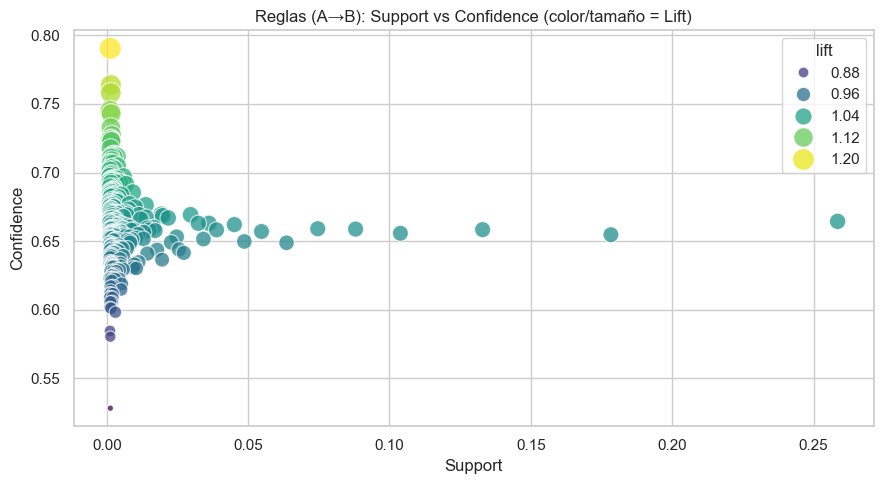

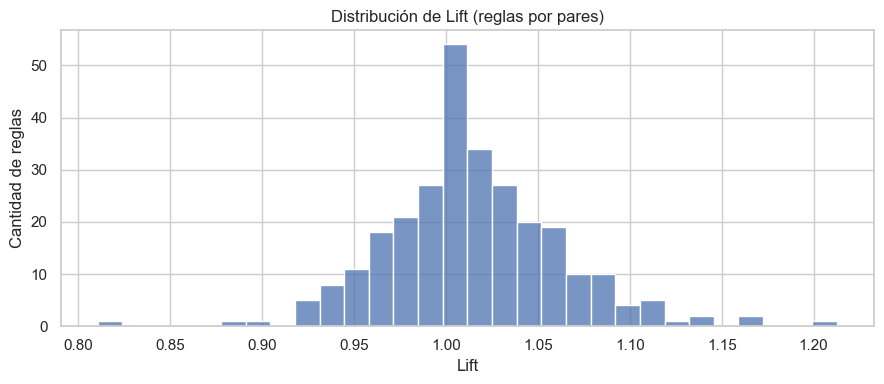

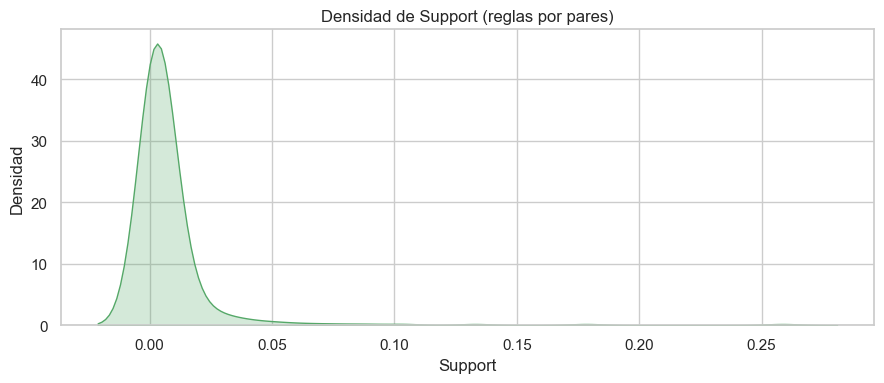

Interpretación: reglas con lift alto y confidence razonable suelen ser las más útiles para ubicar productos cerca.


In [22]:
# Usamos reglas por pares (A->B) del algoritmo ganador
rules_plot = rules_pairs.copy()

# Scatter support vs confidence con lift como color/tamaño
plt.figure(figsize=(9, 5))
sns.scatterplot(
    data=rules_plot,
    x="support",
    y="confidence",
    hue="lift",
    size="lift",
    sizes=(20, 250),
    palette="viridis",
    alpha=0.75,
)
plt.title("Reglas (A→B): Support vs Confidence (color/tamaño = Lift)")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.tight_layout()
plt.show()

# Histograma de lift
plt.figure(figsize=(9, 4))
sns.histplot(rules_plot["lift"].astype(float), bins=30, color="#4C72B0")
plt.title("Distribución de Lift (reglas por pares)")
plt.xlabel("Lift")
plt.ylabel("Cantidad de reglas")
plt.tight_layout()
plt.show()

# Densidad de support
plt.figure(figsize=(9, 4))
sns.kdeplot(rules_plot["support"].astype(float), fill=True, color="#55A868")
plt.title("Densidad de Support (reglas por pares)")
plt.xlabel("Support")
plt.ylabel("Densidad")
plt.tight_layout()
plt.show()

print("Interpretación: reglas con lift alto y confidence razonable suelen ser las más útiles para ubicar productos cerca.")

In [23]:
# 6.1 Agrupaciones recomendadas de productos ("zonas")
# Construimos un grafo con las relaciones de alta afinidad y extraemos componentes conexas.

high_edges = final_pairs_table[final_pairs_table["Nivel de proximidad recomendado"] == "Alta"].copy()

G = nx.Graph()
for _, r in high_edges.iterrows():
    G.add_edge(r["Producto A"], r["Producto B"], weight=float(r["Lift"]))

components = [list(c) for c in nx.connected_components(G) if len(c) >= 2]
components = sorted(components, key=len, reverse=True)

print(f"Zonas detectadas (Alta afinidad): {len(components)}")

# Mostrar hasta 10 zonas
for i, comp in enumerate(components[:10], start=1):
    print(f"\nZona {i} — Alta afinidad (productos que se venden juntos con frecuencia):")
    for item in sorted(comp):
        print(f"- {item}")

# Opcional: si no hay suficientes zonas de alta afinidad, mostramos también afinidad media como sugerencia
if len(components) == 0:
    print("\nNo se detectaron zonas de alta afinidad con los umbrales actuales.")
    print("Probá bajar min_support_count o relajar el criterio de 'Alta' (lift/confidence).")

Zonas detectadas (Alta afinidad): 0

No se detectaron zonas de alta afinidad con los umbrales actuales.
Probá bajar min_support_count o relajar el criterio de 'Alta' (lift/confidence).


### 6.3 Traducción a decisiones físicas (texto para responsables del depósito)

- **Proximidad Alta**:
  - Estos productos deberían ubicarse **en estanterías contiguas o en el mismo módulo**, porque aparecen juntos de forma consistente.
  - Impacto esperado: menos recorridos en picking y reposición, menor tiempo por pedido.

- **Proximidad Media**:
  - Estos productos conviene ubicarlos **en la misma zona** (por ejemplo, el mismo pasillo o sector), pero no necesariamente “pegados”.
  - Impacto esperado: ayuda a ordenar la zona por “familias de compra” sin forzar un armado rígido.

- **Proximidad Baja**:
  - No es prioritario ubicarlos cerca por afinidad de compra.
  - En estos casos, conviene decidir por otras variables: rotación (ABC), volumen/peso, seguridad, fragilidad, normativa eléctrica, etc.

> Consejo: si vas a rediseñar el layout, empezá por 3–5 zonas de alta afinidad y validalas con el personal de depósito (ellos conocen excepciones operativas).

## Extensión 1 — Rotación de productos (criterio complementario)

Hasta acá, el análisis se basó en **co-ocurrencia**: qué productos aparecen juntos en una misma compra.

Ahora agregamos un segundo criterio muy usado en depósitos y tiendas:

- **Rotación**: qué productos “se mueven” más.

¿Por qué importa para el layout?

- Los productos de **alta rotación** suelen ir en zonas más accesibles (“zonas calientes”), porque se buscan y se reponen más seguido.
- Si un producto se vende muchísimo, conviene que el personal recorra menos distancia para pickearlo.
- Incluso si un producto no tiene muchas asociaciones, su rotación puede justificar una ubicación privilegiada.

En esta sección calculamos rotación por producto con dos miradas:

- **Frecuencia**: en cuántas transacciones aparece (presencia en cestas).
- **Unidades**: cuántas unidades se vendieron en total (suma de `quantity`).


In [24]:
# Métricas de rotación por producto (usamos el dataset limpio _df)

rotation = (
    _df.groupby("product_name")
    .agg(
        tx_frequency=("transaction_id", "nunique"),
        units_sold=("quantity", "sum"),
    )
    .reset_index()
)

rotation["tx_frequency_rate"] = rotation["tx_frequency"] / _df["transaction_id"].nunique()

# Clasificación por percentiles (defendible y fácil de explicar)
# Alta rotación: top 20% | Media: 20-50% | Baja: resto
p80_freq = rotation["tx_frequency"].quantile(0.80)
p50_freq = rotation["tx_frequency"].quantile(0.50)

p80_units = rotation["units_sold"].quantile(0.80)
p50_units = rotation["units_sold"].quantile(0.50)


def tier(value: float, p80: float, p50: float) -> str:
    if value >= p80:
        return "Alta"
    if value >= p50:
        return "Media"
    return "Baja"

rotation["rotacion_freq"] = rotation["tx_frequency"].apply(lambda v: tier(v, p80_freq, p50_freq))
rotation["rotacion_units"] = rotation["units_sold"].apply(lambda v: tier(v, p80_units, p50_units))

# Un índice simple (0 a 1) para comparar productos de forma conjunta
# Promediamos el percentil de frecuencia y el de unidades.
rotation["freq_pct"] = rotation["tx_frequency"].rank(pct=True)
rotation["units_pct"] = rotation["units_sold"].rank(pct=True)
rotation["rotation_index"] = 0.5 * (rotation["freq_pct"] + rotation["units_pct"])

rotation = rotation.sort_values("rotation_index", ascending=False)

display(rotation.head(15))
print("\nResumen de tiers (frecuencia):")
print(rotation["rotacion_freq"].value_counts())
print("\nResumen de tiers (unidades):")
print(rotation["rotacion_units"].value_counts())

,product_name,tx_frequency,units_sold,tx_frequency_rate,rotacion_freq,rotacion_units,freq_pct,units_pct,rotation_index
317,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,46574,348198,0.573465,Alta,Alta,1.000000,1.000000,1.000000
3266,RODA - LLAVE COMPLETA COMBINADA BL - SCHNEIDER,27445,206570,0.337930,Alta,Alta,0.999747,0.999747,0.999747
3718,TORNILLO PTA AGUJA FOSF NEGRO P/GRUESO 6 X 2` X UD-,19143,142717,0.235708,Alta,Alta,0.999494,0.999494,0.999494
1938,GABINETE IP67 15X15X10 TRANSPARENTE ZG 1515 TR - CABRERA,14140,106890,0.174106,Alta,Alta,0.999241,0.999241,0.999241
2718,PANEL LED CIRCULAR 18W LF - ECO,11087,83129,0.136514,Alta,Alta,0.998988,0.998988,0.998988
764,CABLE SUBTERRANEO AL 3X240+120 MM C/ NORMAS IRAM,9345,70096,0.115065,Alta,Alta,0.998735,0.998735,0.998735
3309,RUMA APLIQUE PARED P/DICRO 1L BL RU-L1 - VGL,7887,58962,0.097113,Alta,Alta,0.998483,0.998483,0.998483
1135,CAPACITOR 25 MF 450V MONOFASICO CORILUX CCT018,6840,51716,0.084221,Alta,Alta,0.998230,0.998230,0.998230
3564,TECLA SMART 2 CANALES AC110-240V MAX 10A BL TSX2B - MACROLED,5824,43732,0.071711,Alta,Alta,0.997977,0.997977,0.997977
948,CABLE VAINA REDONDO BLANCO 2X0.50MM - LUMIPACK,5230,39581,0.064397,Alta,Alta,0.997724,0.997724,0.997724



Resumen de tiers (frecuencia):
rotacion_freq
Baja     1919
Media    1232
Alta      803
Name: count, dtype: int64

Resumen de tiers (unidades):
rotacion_units
Baja     1967
Media    1196
Alta      791
Name: count, dtype: int64


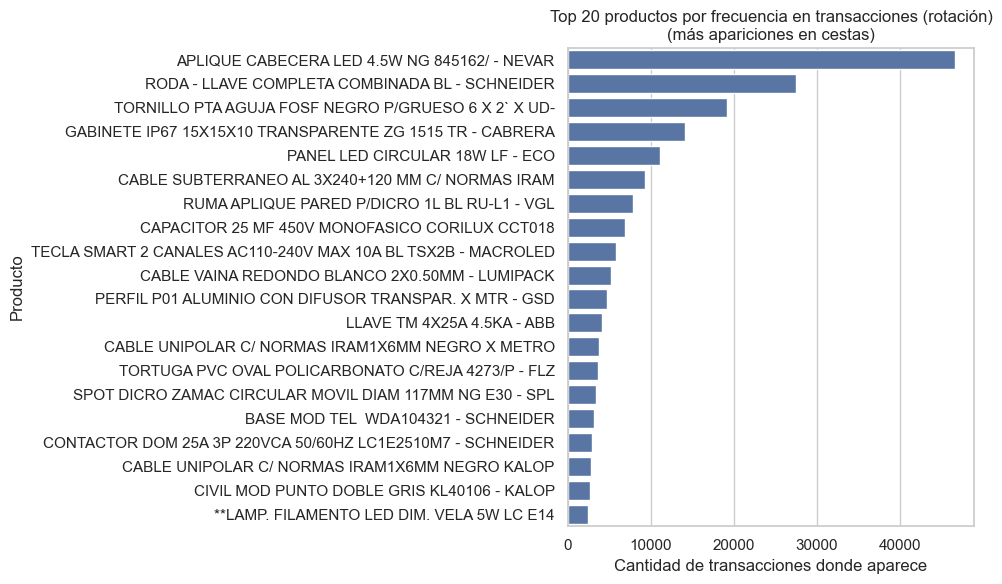

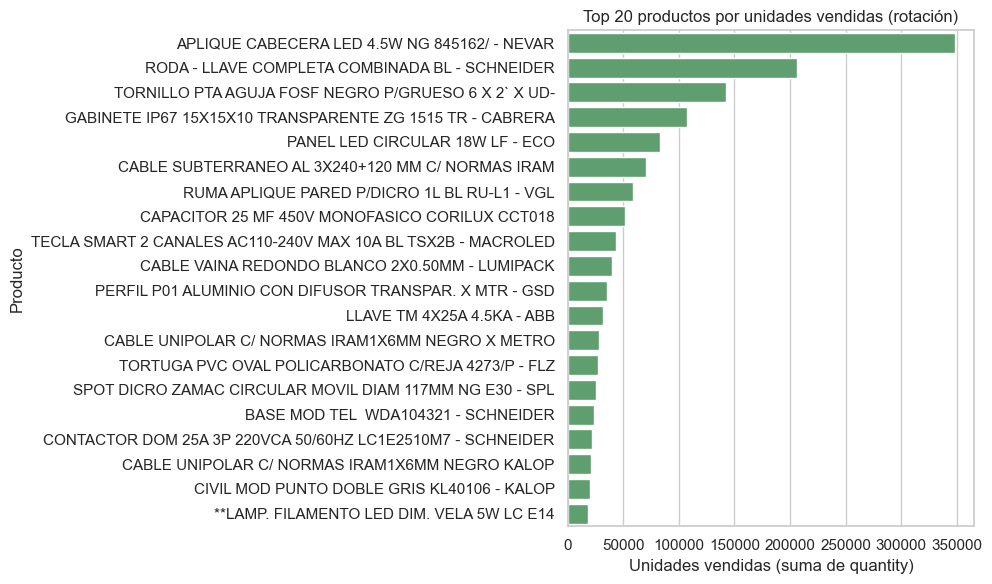

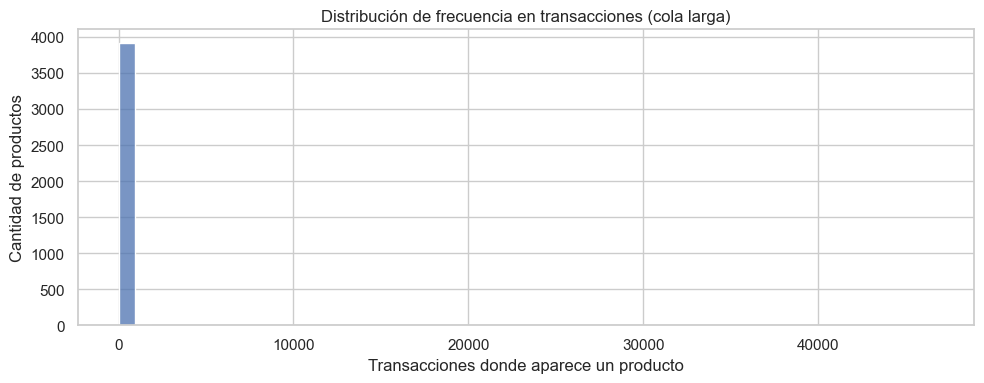

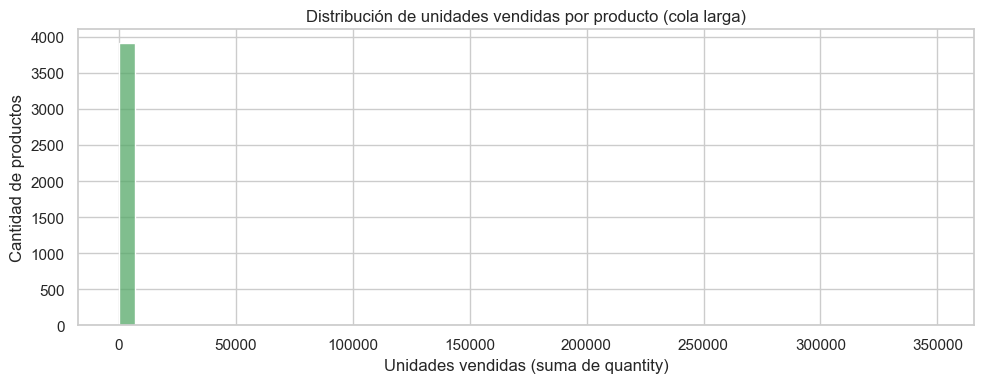

In [25]:
# Gráficos de rotación

TOP_N = 20

rot_top_freq = rotation.sort_values("tx_frequency", ascending=False).head(TOP_N)
rot_top_units = rotation.sort_values("units_sold", ascending=False).head(TOP_N)

plt.figure(figsize=(10, 6))
sns.barplot(data=rot_top_freq, y="product_name", x="tx_frequency", color="#4C72B0")
plt.title(f"Top {TOP_N} productos por frecuencia en transacciones (rotación)\n(más apariciones en cestas)")
plt.xlabel("Cantidad de transacciones donde aparece")
plt.ylabel("Producto")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=rot_top_units, y="product_name", x="units_sold", color="#55A868")
plt.title(f"Top {TOP_N} productos por unidades vendidas (rotación)")
plt.xlabel("Unidades vendidas (suma de quantity)")
plt.ylabel("Producto")
plt.tight_layout()
plt.show()

# Distribución (cola larga típica)
plt.figure(figsize=(10, 4))
sns.histplot(rotation["tx_frequency"], bins=50, color="#4C72B0")
plt.title("Distribución de frecuencia en transacciones (cola larga)")
plt.xlabel("Transacciones donde aparece un producto")
plt.ylabel("Cantidad de productos")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(rotation["units_sold"], bins=50, color="#55A868")
plt.title("Distribución de unidades vendidas por producto (cola larga)")
plt.xlabel("Unidades vendidas (suma de quantity)")
plt.ylabel("Cantidad de productos")
plt.tight_layout()
plt.show()

## Extensión 2 — Cruce: co-ocurrencia + rotación (prioridad máxima)

Las reglas por sí solas dicen qué productos se compran juntos, pero no siempre dicen qué conviene priorizar.

En un depósito real, una relación puede ser muy fuerte, pero si ambos productos casi no se mueven, el impacto de moverlos cerca puede ser menor.

Por eso, en esta sección cruzamos:

- **Fuerza de relación** (lift/confidence/support)
- **Rotación** de los productos involucrados

y creamos una **métrica compuesta** simple y explicable:

\[
\text{score\_layout\_regla} = \text{lift} \times \text{rotación\_promedio}
\]

La idea es priorizar reglas que sean a la vez:

- “Se compran juntos” (alta afinidad)
- “Se mueven mucho” (alta rotación)


In [26]:
# Tabla de reglas enriquecida con rotación (por product_name)

# Mapa product_name -> rotation_index (0..1). Si un producto no aparece, asumimos rotación baja.
rot_map = rotation.set_index("product_name")["rotation_index"].to_dict() if "rotation_index" in rotation.columns else {}

rules_enriched = final_pairs_table.copy()
rules_enriched["rot_A"] = rules_enriched["Producto A"].map(lambda x: float(rot_map.get(x, 0.0)))
rules_enriched["rot_B"] = rules_enriched["Producto B"].map(lambda x: float(rot_map.get(x, 0.0)))
rules_enriched["rotacion_promedio"] = (rules_enriched["rot_A"] + rules_enriched["rot_B"]) / 2.0

# Métrica compuesta simple
rules_enriched["score_layout_regla"] = rules_enriched["Lift"] * rules_enriched["rotacion_promedio"]

# Reglas que priorizamos (definición simple y defendible)
# - Afinidad: Lift >= 1.2 y Confidence >= 0.30
# - Rotación: rotación promedio >= 0.80 (top 20% aprox.)

rules_enriched["prioridad_maxima"] = (
    (rules_enriched["Lift"] >= 1.2)
    & (rules_enriched["Confidence"] >= 0.30)
    & (rules_enriched["rotacion_promedio"] >= 0.80)
)

rules_ranked = rules_enriched.sort_values(["prioridad_maxima", "score_layout_regla", "Lift", "Confidence"], ascending=[False, False, False, False])

cols_show = [
    "Producto A",
    "Producto B",
    "Support",
    "Confidence",
    "Lift",
    "Nivel de proximidad recomendado",
    "rotacion_promedio",
    "score_layout_regla",
    "prioridad_maxima",
]

display(rules_ranked[cols_show].head(30))

print(f"Reglas marcadas como prioridad máxima: {int(rules_ranked['prioridad_maxima'].sum()):,}")

,Producto A,Producto B,Support,Confidence,Lift,Nivel de proximidad recomendado,rotacion_promedio,score_layout_regla,prioridad_maxima
183,MEDIA ESFERA COLG 1L P/E27 DIAM 50CM BL 0306/D - FLZ,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001232,0.790476,1.212748,Media,0.963297,1.168236,True
127,ESTAÑO EN CARRETE 500GR 60/40 1MM EST7500 - JA,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001440,0.763780,1.171790,Baja,0.965794,1.131708,False
84,CAMBRE SIGLO XXII TAPA 4 MOD-GRIS 14704,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001396,0.758065,1.163022,Baja,0.967501,1.125225,False
52,CABLE PRENSAMBLADO DE COBRE 2X6MM C/ NORMAS IRAM,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001544,0.742857,1.139691,Baja,0.969746,1.105210,False
24,APLIQUE PARED JAULA DIAMANTE BL CJ6691 - SJT,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001173,0.745283,1.143412,Baja,0.960357,1.098084,False
167,LISTON LED BAJO ALACENA 35W LF 120CM 401966 - INTERELEC,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001425,0.732824,1.124298,Baja,0.968987,1.089431,False
20,**BIPIN LED 5W DIMERIZABLE - G9 LC 404106 - INTERELEC,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001781,0.727273,1.115781,Baja,0.974393,1.087209,False
61,CABLE UNIPOLAR C/ NORMAS IRAM1X1MM MARRON,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001589,0.722973,1.109184,Baja,0.973128,1.079379,False
154,KIT COMPLETO TIRA CONTR SEC,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001589,0.722973,1.109184,Baja,0.972718,1.078923,False
139,GABINETE AZUL/MARFIL PVC IP65 20X30X15CM - CABRERA,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001485,0.724638,1.111738,Baja,0.969651,1.077998,False


Reglas marcadas como prioridad máxima: 1


### Gráficos combinados: co-ocurrencia + rotación

Estos gráficos hacen más visible algo clave para layout:

- **No basta con que un par sea fuerte (lift alto)** si casi no se vende.
- **No basta con que algo rote mucho** si no tiene relaciones claras.

Buscamos el “punto dulce”: productos que se mueven y además tienen asociaciones útiles.


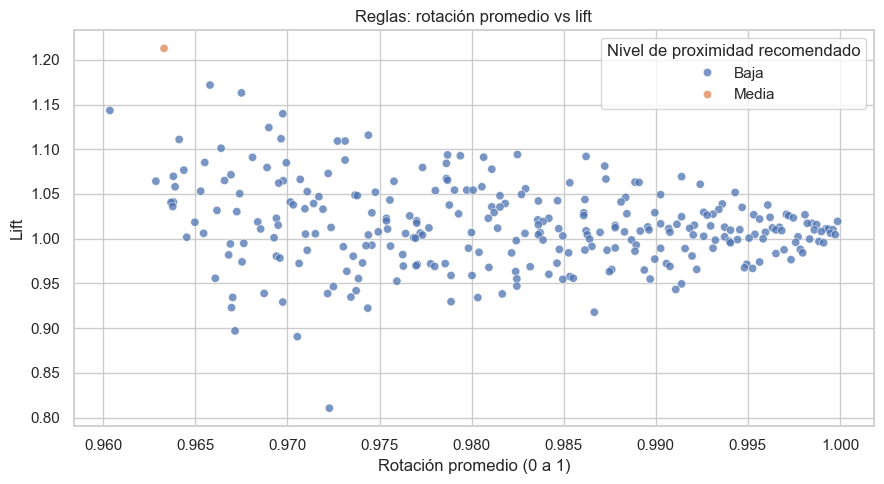

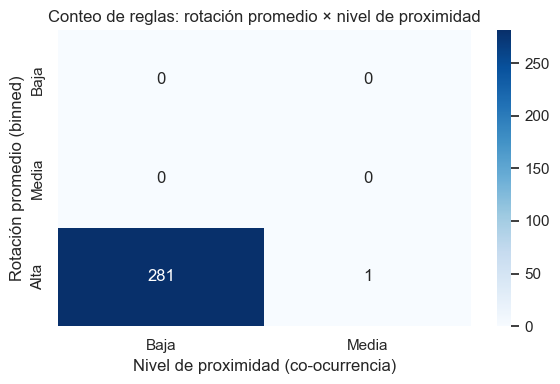

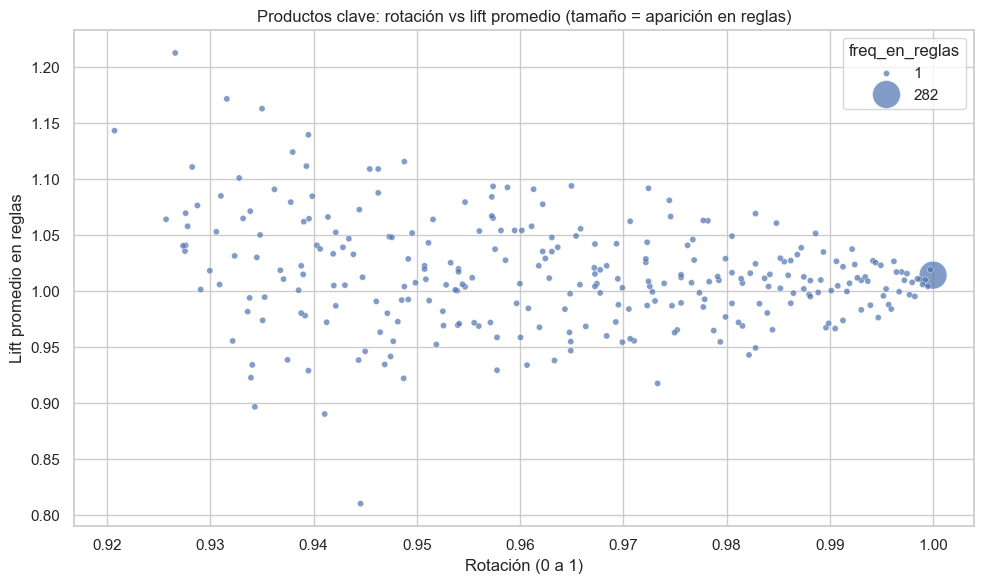

Interpretación: productos en la esquina superior derecha (alta rotación y lift alto) suelen ser prioridad máxima de layout.


In [27]:
# 1) Scatter: rotación promedio vs lift (a nivel regla)

plt.figure(figsize=(9, 5))
sns.scatterplot(
    data=rules_enriched,
    x="rotacion_promedio",
    y="Lift",
    hue="Nivel de proximidad recomendado",
    alpha=0.75,
)
plt.title("Reglas: rotación promedio vs lift")
plt.xlabel("Rotación promedio (0 a 1)")
plt.ylabel("Lift")
plt.tight_layout()
plt.show()

# 2) Heatmap: rotación (binned) x nivel de co-ocurrencia (proximidad) — conteo de reglas
bins = pd.cut(rules_enriched["rotacion_promedio"], bins=[-0.01, 0.33, 0.66, 1.01], labels=["Baja", "Media", "Alta"])
heat = pd.crosstab(bins, rules_enriched["Nivel de proximidad recomendado"]).reindex(index=["Baja", "Media", "Alta"], fill_value=0)

plt.figure(figsize=(6, 4))
sns.heatmap(heat, annot=True, fmt="d", cmap="Blues")
plt.title("Conteo de reglas: rotación promedio × nivel de proximidad")
plt.xlabel("Nivel de proximidad (co-ocurrencia)")
plt.ylabel("Rotación promedio (binned)")
plt.tight_layout()
plt.show()

# 3) Burbuja a nivel producto: X=rotación, Y=lift promedio, tamaño=frecuencia en reglas
product_stats = []

for col in ["Producto A", "Producto B"]:
    tmp = rules_enriched[[col, "Lift"]].rename(columns={col: "product_name"})
    tmp["rotation_index"] = tmp["product_name"].map(lambda x: float(rot_map.get(x, 0.0)))
    product_stats.append(tmp)

ps = pd.concat(product_stats, ignore_index=True)
ps_agg = ps.groupby("product_name").agg(
    rotation_index=("rotation_index", "mean"),
    lift_promedio=("Lift", "mean"),
    freq_en_reglas=("Lift", "count"),
).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=ps_agg,
    x="rotation_index",
    y="lift_promedio",
    size="freq_en_reglas",
    sizes=(20, 400),
    alpha=0.70,
    color="#4C72B0",
)
plt.title("Productos clave: rotación vs lift promedio (tamaño = aparición en reglas)")
plt.xlabel("Rotación (0 a 1)")
plt.ylabel("Lift promedio en reglas")
plt.tight_layout()
plt.show()

print("Interpretación: productos en la esquina superior derecha (alta rotación y lift alto) suelen ser prioridad máxima de layout.")

## Extensión 3 — Visualizaciones comparativas (performance y calidad)

En vez de mirar sólo tablas, estas visualizaciones ayudan a entender rápido:

- Qué algoritmo **tarda menos**
- Cuál genera **más reglas**
- Cómo es la **distribución del lift** (si tiende a reglas fuertes o más débiles)

Estas figuras reutilizan los resultados ya calculados (no vuelven a ejecutar algoritmos).

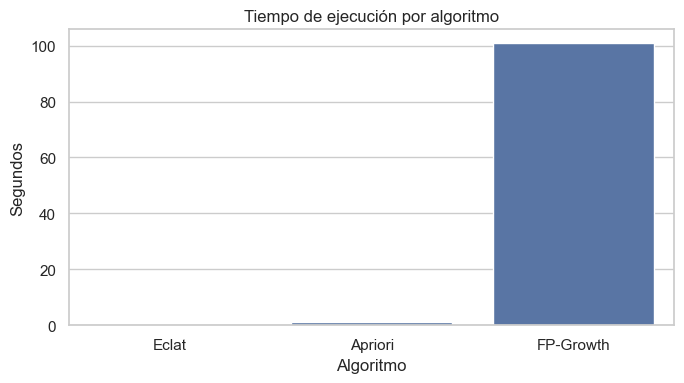

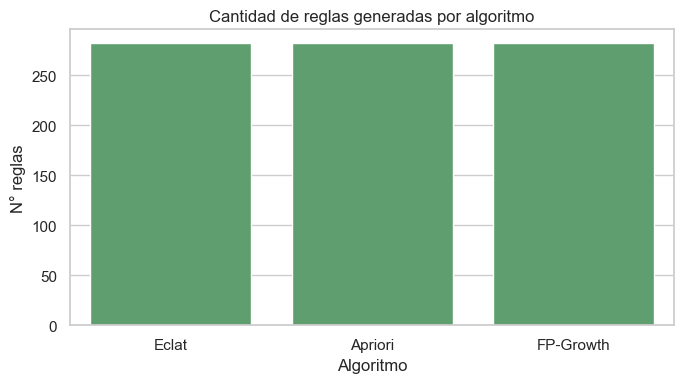

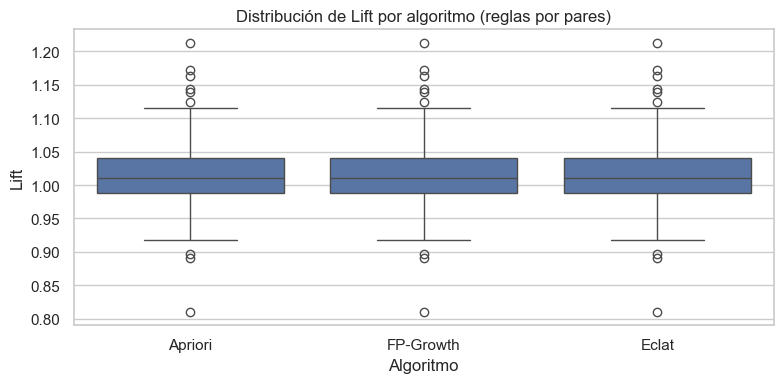

In [28]:
# Performance: tiempo y cantidad de reglas

perf = comparison_df.copy()

plt.figure(figsize=(7, 4))
sns.barplot(data=perf, x="Algoritmo", y="Tiempo (seg)", color="#4C72B0")
plt.title("Tiempo de ejecución por algoritmo")
plt.ylabel("Segundos")
plt.xlabel("Algoritmo")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
sns.barplot(data=perf, x="Algoritmo", y="Cantidad de reglas", color="#55A868")
plt.title("Cantidad de reglas generadas por algoritmo")
plt.ylabel("N° reglas")
plt.xlabel("Algoritmo")
plt.tight_layout()
plt.show()

# Distribución de lift por algoritmo
lift_rows = []
for res in results:
    if res.rules is None or res.rules.empty:
        continue
    # Solo reglas por pares para comparación consistente
    rr = res.rules[
        res.rules["antecedents"].apply(lambda x: len(x) == 1)
        & res.rules["consequents"].apply(lambda x: len(x) == 1)
    ]
    for v in rr["lift"].astype(float).values:
        lift_rows.append({"Algoritmo": res.name, "Lift": v})

lift_df = pd.DataFrame(lift_rows)

plt.figure(figsize=(8, 4))
sns.boxplot(data=lift_df, x="Algoritmo", y="Lift")
plt.title("Distribución de Lift por algoritmo (reglas por pares)")
plt.tight_layout()
plt.show()

## Extensión 4 — Visualización de relaciones entre productos (grafo)

Una forma muy intuitiva de explicar “zonas” es un grafo:

- Cada **nodo** es un producto.
- Cada **arista** indica que esos productos tienen una relación fuerte (regla).
- El **tamaño del nodo** representa rotación (más grande = se mueve más).
- El **grosor de la arista** representa la fuerza de la relación (lift).

Para que el gráfico sea legible, mostramos sólo las relaciones más relevantes (las primeras por `score_layout_regla`).

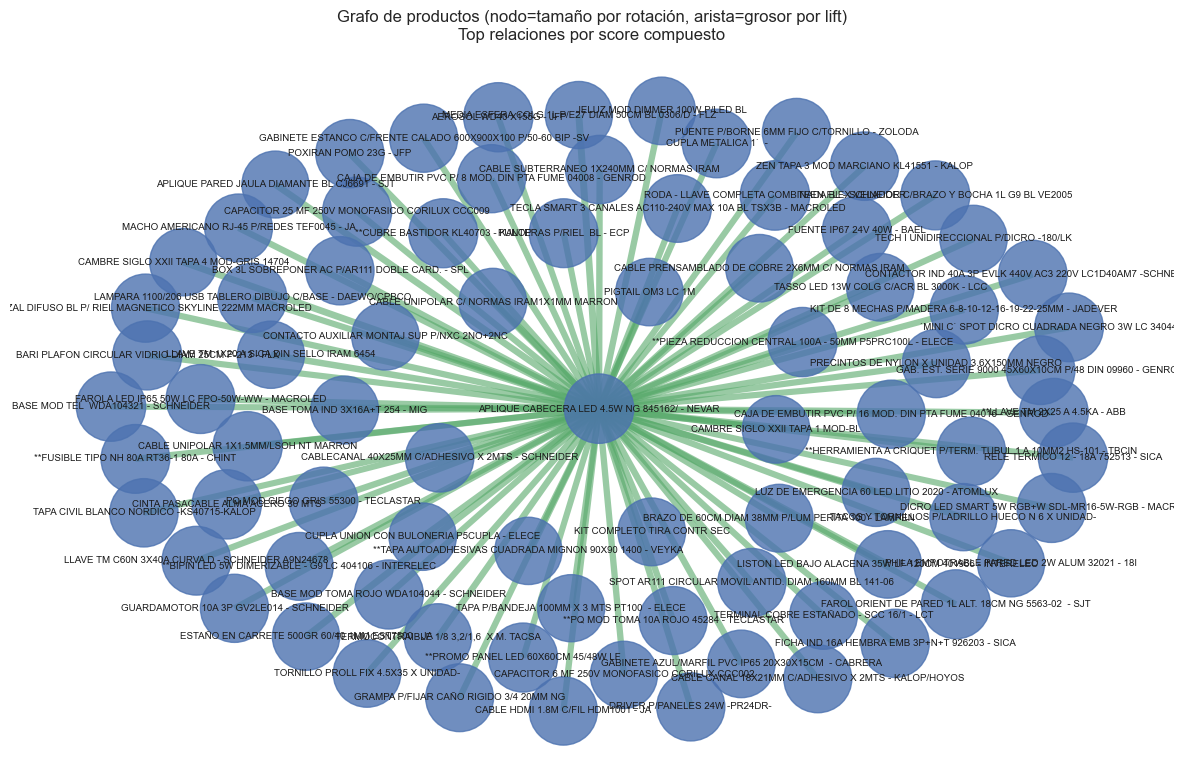

In [29]:
# Grafo de productos (top relaciones)

# Seleccionamos top edges por score compuesto para mantener legibilidad
TOP_EDGES = 80
edges_df = rules_ranked.head(TOP_EDGES).copy()

G2 = nx.Graph()
for _, r in edges_df.iterrows():
    a = r["Producto A"]
    b = r["Producto B"]
    G2.add_edge(
        a,
        b,
        lift=float(r["Lift"]),
        confidence=float(r["Confidence"]),
        score=float(r["score_layout_regla"]),
        level=str(r["Nivel de proximidad recomendado"]),
    )

# Tamaño de nodo por rotación (0..1) -> escala visual
node_sizes = []
for n in G2.nodes():
    ri = float(rot_map.get(n, 0.0))
    node_sizes.append(300 + 2200 * ri)  # base + escala

pos = nx.spring_layout(G2, seed=42, k=0.35)

# Aristas: grosor por lift
edge_lifts = [G2[u][v]["lift"] for u, v in G2.edges()]
if edge_lifts:
    max_l = max(edge_lifts)
    widths = [1.0 + 4.0 * (l / max_l) for l in edge_lifts]
else:
    widths = 1.0

plt.figure(figsize=(12, 8))

nx.draw_networkx_nodes(G2, pos, node_size=node_sizes, node_color="#4C72B0", alpha=0.80)

nx.draw_networkx_edges(G2, pos, width=widths, edge_color="#55A868", alpha=0.60)

nx.draw_networkx_labels(G2, pos, font_size=7)

plt.title("Grafo de productos (nodo=tamaño por rotación, arista=grosor por lift)\nTop relaciones por score compuesto")
plt.axis("off")
plt.tight_layout()
plt.show()

### Matriz de adyacencia (zona lógica)

Otra forma de ver “zonas” sin tecnicismos es una matriz:

- Filas/columnas = productos
- Un valor alto indica una relación fuerte (por ejemplo, lift alto)

Si aparecen bloques en el heatmap, suelen representar **grupos de productos** que conviene ubicar cerca.


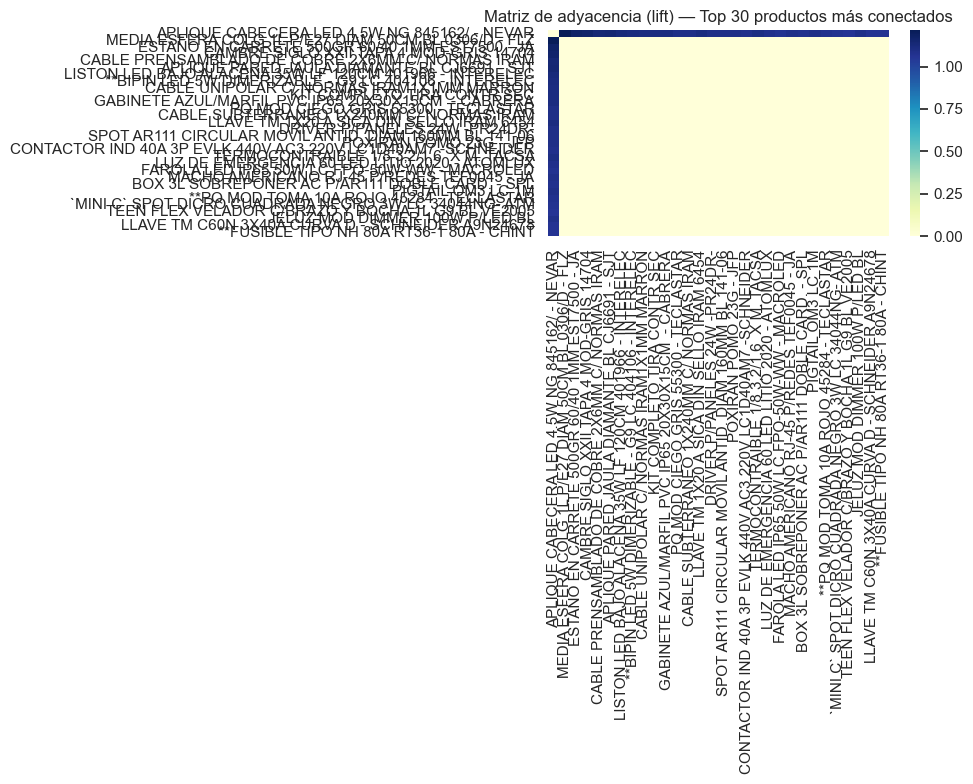

In [30]:
# Matriz de adyacencia visual (limitamos N para que sea legible)

TOP_NODES = 30

# Elegimos nodos más conectados (mayor grado) para mostrar la parte más “interesante”
degrees = sorted(G2.degree, key=lambda x: x[1], reverse=True)
keep_nodes = [n for n, _ in degrees[:TOP_NODES]]

# Construimos matriz de lift (0 si no hay arista)
mat = np.zeros((len(keep_nodes), len(keep_nodes)), dtype=float)

idx = {n: i for i, n in enumerate(keep_nodes)}
for u, v, d in G2.edges(data=True):
    if u in idx and v in idx:
        i, j = idx[u], idx[v]
        w = float(d.get("lift", 0.0))
        mat[i, j] = w
        mat[j, i] = w

plt.figure(figsize=(10, 8))
sns.heatmap(mat, xticklabels=keep_nodes, yticklabels=keep_nodes, cmap="YlGnBu")
plt.title(f"Matriz de adyacencia (lift) — Top {TOP_NODES} productos más conectados")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Extensión 5 — Cierre 100% orientado a layout físico (prioridades)

Para pasar de análisis a acción, conviene tener una lista corta y clara.

En esta sección creamos una tabla priorizada de **relaciones** (pares de productos) que combina:

- Co-ocurrencia (lift/confidence)
- Rotación (qué tan “calientes” son los productos)

y asigna un nivel de prioridad de layout:

- **Muy Alta**: mover primero / ubicar contiguo
- **Alta**: mover luego / misma zona
- **Media**: considerar si hay espacio o si mejora recorridos

Esto ayuda a decidir por dónde empezar cuando el depósito tiene muchas restricciones y no se puede mover todo.

In [31]:
# Tabla priorizada de reglas para layout (cruce co-ocurrencia + rotación)

rules_priority = rules_ranked.copy()

# Priorización simple y explicable
# - Muy Alta: prioridad_maxima=True
# - Alta: lift>=1.2 y confidence>=0.30 y rotación_promedio>=0.50
# - Media: lift>=1.1 y confidence>=0.20

def rule_priority(row) -> str:
    if bool(row["prioridad_maxima"]):
        return "Muy Alta"
    if (row["Lift"] >= 1.2) and (row["Confidence"] >= 0.30) and (row["rotacion_promedio"] >= 0.50):
        return "Alta"
    if (row["Lift"] >= 1.1) and (row["Confidence"] >= 0.20):
        return "Media"
    return "Baja"

rules_priority["prioridad_layout"] = rules_priority.apply(rule_priority, axis=1)

prio_order = pd.CategoricalDtype(["Muy Alta", "Alta", "Media", "Baja"], ordered=True)
rules_priority["prioridad_layout"] = rules_priority["prioridad_layout"].astype(prio_order)

rules_priority = rules_priority.sort_values(["prioridad_layout", "score_layout_regla"], ascending=[True, False])

show_cols = [
    "prioridad_layout",
    "Producto A",
    "Producto B",
    "Support",
    "Confidence",
    "Lift",
    "rotacion_promedio",
    "score_layout_regla",
]

display(rules_priority[show_cols].head(50))

print("\nConteo por prioridad:")
print(rules_priority["prioridad_layout"].value_counts())

,prioridad_layout,Producto A,Producto B,Support,Confidence,Lift,rotacion_promedio,score_layout_regla
183,Muy Alta,MEDIA ESFERA COLG 1L P/E27 DIAM 50CM BL 0306/D - FLZ,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001232,0.790476,1.212748,0.963297,1.168236
127,Media,ESTAÑO EN CARRETE 500GR 60/40 1MM EST7500 - JA,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001440,0.763780,1.171790,0.965794,1.131708
84,Media,CAMBRE SIGLO XXII TAPA 4 MOD-GRIS 14704,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001396,0.758065,1.163022,0.967501,1.125225
52,Media,CABLE PRENSAMBLADO DE COBRE 2X6MM C/ NORMAS IRAM,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001544,0.742857,1.139691,0.969746,1.105210
24,Media,APLIQUE PARED JAULA DIAMANTE BL CJ6691 - SJT,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001173,0.745283,1.143412,0.960357,1.098084
167,Media,LISTON LED BAJO ALACENA 35W LF 120CM 401966 - INTERELEC,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001425,0.732824,1.124298,0.968987,1.089431
20,Media,**BIPIN LED 5W DIMERIZABLE - G9 LC 404106 - INTERELEC,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001781,0.727273,1.115781,0.974393,1.087209
61,Media,CABLE UNIPOLAR C/ NORMAS IRAM1X1MM MARRON,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001589,0.722973,1.109184,0.973128,1.079379
154,Media,KIT COMPLETO TIRA CONTR SEC,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001589,0.722973,1.109184,0.972718,1.078923
139,Media,GABINETE AZUL/MARFIL PVC IP65 20X30X15CM - CABRERA,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,0.001485,0.724638,1.111738,0.969651,1.077998



Conteo por prioridad:
prioridad_layout
Baja        270
Media        11
Muy Alta      1
Alta          0
Name: count, dtype: int64


## Sección final — Tabla de decisión de layout por producto (y persistencia en base)

Hasta este punto, el notebook produce reglas entre productos (co-ocurrencia) y una lectura de rotación.

En esta sección construimos una **tabla final a nivel producto**, pensada para usarse como insumo directo del diseño del depósito y para poder consultarla desde SQL sin re-ejecutar el notebook.

### Cómo se decide la ubicación (reglas simples y defendibles)

Usamos dos señales complementarias:

- **Rotación** (qué tanto se mueve el producto): si un producto aparece en muchas ventas y/o vende muchas unidades, conviene que esté más accesible.
- **Co-ocurrencia** (qué tanto se compra junto a otros): si un producto tiene relaciones fuertes con otros, conviene ubicarlo cerca de esos productos para reducir recorridos.

Con eso definimos:

- `nivel_rotacion`: **Alta / Media / Baja**
- `nivel_coocurrencia`: **Alta / Media / Baja** (según las reglas ya calculadas)
- `prioridad_layout`: **Muy Alta / Alta / Media / Baja**
- `ubicacion_sugerida`: una de estas cuatro opciones (de más accesible a menos accesible):
  - “Próxima a la entrada (máxima accesibilidad)”
  - “Cerca de la entrada”
  - “Media distancia”
  - “Lejos de la entrada”

> Nota práctica: esta recomendación es un punto de partida basado en patrones históricos. Luego se ajusta con restricciones reales (espacio, peso, seguridad, fragilidad, normativa, etc.).

In [32]:
# 1) Construcción de la tabla final de layout por producto

# Rotación a nivel product_id (requerimiento)
prod_base = (
    _df.groupby("product_id")
    .agg(
        product_name=("product_name", lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]),
        product_category=("product_category", lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]),
        product_type=("product_type", lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]),
        frecuencia_transacciones=("transaction_id", "nunique"),
        unidades_totales_vendidas=("quantity", "sum"),
    )
    .reset_index()
)

# Nivel de rotación (por percentiles; fácil de defender)
p80_freq_p = prod_base["frecuencia_transacciones"].quantile(0.80)
p50_freq_p = prod_base["frecuencia_transacciones"].quantile(0.50)

p80_units_p = prod_base["unidades_totales_vendidas"].quantile(0.80)
p50_units_p = prod_base["unidades_totales_vendidas"].quantile(0.50)


def tier_3(v: float, p80: float, p50: float) -> str:
    if v >= p80:
        return "Alta"
    if v >= p50:
        return "Media"
    return "Baja"

prod_base["rot_freq"] = prod_base["frecuencia_transacciones"].apply(lambda v: tier_3(v, p80_freq_p, p50_freq_p))
prod_base["rot_units"] = prod_base["unidades_totales_vendidas"].apply(lambda v: tier_3(v, p80_units_p, p50_units_p))

# Un solo nivel de rotación (combinamos frecuencia + unidades de forma simple)
# Si cualquiera de las dos es Alta => Alta; sino si cualquiera es Media => Media; sino Baja.

def combine_rotation(a: str, b: str) -> str:
    if (a == "Alta") or (b == "Alta"):
        return "Alta"
    if (a == "Media") or (b == "Media"):
        return "Media"
    return "Baja"

prod_base["nivel_rotacion"] = prod_base.apply(lambda r: combine_rotation(r["rot_freq"], r["rot_units"]), axis=1)

# Nivel de co-ocurrencia por producto, derivado de reglas ya calculadas.
# Regla simple: si el producto aparece en alguna relación "Alta" => Alta; si no, pero aparece en alguna "Media" => Media; else Baja.

level_rank = {"Baja": 1, "Media": 2, "Alta": 3}

cooc_max = {}
for _, rr in final_pairs_table[["Producto A", "Producto B", "Nivel de proximidad recomendado"]].iterrows():
    lvl = rr["Nivel de proximidad recomendado"]
    for p in (rr["Producto A"], rr["Producto B"]):
        cooc_max[p] = max(cooc_max.get(p, 1), level_rank.get(lvl, 1))

rank_to_level = {1: "Baja", 2: "Media", 3: "Alta"}

prod_base["nivel_coocurrencia"] = prod_base["product_name"].map(lambda n: rank_to_level.get(cooc_max.get(n, 1), "Baja"))

# Prioridad de layout: combinación ordinal simple (explicable)
# Score = rotación (1-3) + co-ocurrencia (1-3)

score_rot = prod_base["nivel_rotacion"].map(level_rank)
score_cooc = prod_base["nivel_coocurrencia"].map(level_rank)
prod_base["score_layout"] = (score_rot + score_cooc).astype(int)


def layout_priority(score: int) -> str:
    if score >= 6:
        return "Muy Alta"
    if score == 5:
        return "Alta"
    if score == 4:
        return "Media"
    return "Baja"

prod_base["prioridad_layout"] = prod_base["score_layout"].apply(layout_priority)

# 2) Asignación de ubicación física sugerida

def suggested_location(priority: str) -> str:
    return {
        "Muy Alta": "Próxima a la entrada (máxima accesibilidad)",
        "Alta": "Cerca de la entrada",
        "Media": "Media distancia",
        "Baja": "Lejos de la entrada",
    }[priority]

prod_base["ubicacion_sugerida"] = prod_base["prioridad_layout"].apply(suggested_location)

product_layout = prod_base[[
    "product_id",
    "product_name",
    "product_category",
    "product_type",
    "frecuencia_transacciones",
    "unidades_totales_vendidas",
    "nivel_rotacion",
    "nivel_coocurrencia",
    "prioridad_layout",
    "ubicacion_sugerida",
]].copy()

product_layout.head()

,product_id,product_name,product_category,product_type,frecuencia_transacciones,unidades_totales_vendidas,nivel_rotacion,nivel_coocurrencia,prioridad_layout,ubicacion_sugerida
0,1,RELE TERMICO P/CONT E12/E38 9/13A LRE16 - SCHNEIDER,Térmicas y disyuntores,Materiales eléctricos,14,115,Media,Baja,Baja,Lejos de la entrada
1,2,CAMBRE BAUHAUS MOD COMB.DOBLE-GRIS 6121,Comando y señalización,Materiales eléctricos,18,123,Media,Baja,Baja,Lejos de la entrada
2,3,CAMBRE SIGLO XXII MOD PULSADOR-GRIS 17502,Comando y señalización,Materiales eléctricos,4,23,Baja,Baja,Baja,Lejos de la entrada
3,4,ENCHUFE 15A P/NEON 220V,Llaves de luz y fichas,Materiales eléctricos,30,226,Media,Baja,Baja,Lejos de la entrada
4,5,ENCHUFE 15A P/NEON COB 220V,Llaves de luz y fichas,Materiales eléctricos,8,86,Baja,Baja,Baja,Lejos de la entrada


In [33]:
# 3) Visualización (tabla legible y ordenada)

priority_order = pd.CategoricalDtype(["Muy Alta", "Alta", "Media", "Baja"], ordered=True)
rot_order = pd.CategoricalDtype(["Alta", "Media", "Baja"], ordered=True)
cooc_order = pd.CategoricalDtype(["Alta", "Media", "Baja"], ordered=True)

product_layout_view = product_layout.copy()
product_layout_view["prioridad_layout"] = product_layout_view["prioridad_layout"].astype(priority_order)
product_layout_view["nivel_rotacion"] = product_layout_view["nivel_rotacion"].astype(rot_order)
product_layout_view["nivel_coocurrencia"] = product_layout_view["nivel_coocurrencia"].astype(cooc_order)

product_layout_view = product_layout_view.sort_values(
    ["prioridad_layout", "frecuencia_transacciones"],
    ascending=[True, False],
)

display(product_layout_view.head(50))
print(f"\nProductos totales en tabla final: {len(product_layout_view):,}")

,product_id,product_name,product_category,product_type,frecuencia_transacciones,unidades_totales_vendidas,nivel_rotacion,nivel_coocurrencia,prioridad_layout,ubicacion_sugerida
328,329,APLIQUE CABECERA LED 4.5W NG 845162/ - NEVAR,Apliques pared,Iluminación,46574,348198,Alta,Media,Alta,Cerca de la entrada
2564,2567,MEDIA ESFERA COLG 1L P/E27 DIAM 50CM BL 0306/D - FLZ,Colgantes,Iluminación,108,913,Alta,Media,Alta,Cerca de la entrada
3277,3281,RODA - LLAVE COMPLETA COMBINADA BL - SCHNEIDER,Llaves de luz y fichas,Materiales eléctricos,27445,206570,Alta,Baja,Media,Media distancia
3728,3732,TORNILLO PTA AGUJA FOSF NEGRO P/GRUESO 6 X 2` X UD-,Herramientas,Materiales eléctricos,19143,142717,Alta,Baja,Media,Media distancia
1951,1953,GABINETE IP67 15X15X10 TRANSPARENTE ZG 1515 TR - CABRERA,Gabinetes eléctricos,Materiales eléctricos,14140,106890,Alta,Baja,Media,Media distancia
2731,2735,PANEL LED CIRCULAR 18W LF - ECO,LED,Iluminación,11087,83129,Alta,Baja,Media,Media distancia
778,779,CABLE SUBTERRANEO AL 3X240+120 MM C/ NORMAS IRAM,Cables,Materiales eléctricos,9345,70096,Alta,Baja,Media,Media distancia
3320,3324,RUMA APLIQUE PARED P/DICRO 1L BL RU-L1 - VGL,Apliques pared,Iluminación,7887,58962,Alta,Baja,Media,Media distancia
1147,1149,CAPACITOR 25 MF 450V MONOFASICO CORILUX CCT018,Comando y señalización,Materiales eléctricos,6840,51716,Alta,Baja,Media,Media distancia
3574,3578,TECLA SMART 2 CANALES AC110-240V MAX 10A BL TSX2B - MACROLED,Comando y señalización,Materiales eléctricos,5824,43732,Alta,Baja,Media,Media distancia



Productos totales en tabla final: 3,964


In [34]:
# 4) Persistencia en base de datos (PostgreSQL)
# Decisión: usamos if_exists="replace" para que el resultado sea reproducible.
# - Si la tabla existe, se reemplaza completamente.
# - Si no existe, se crea.
# En un escenario productivo, podría preferirse TRUNCATE + INSERT para conservar permisos/índices.

table_name = "product_layout_recommendation"

product_layout_to_save = product_layout.copy()

product_layout_to_save.to_sql(
    name=table_name,
    con=engine,
    schema="datamining",
    if_exists="replace",
    index=False,
    method="multi",
    chunksize=5000,
)

print(f"Tabla guardada en PostgreSQL: datamining.{table_name}")

# Verificación rápida (conteo)
verify_df = pd.read_sql(f"SELECT COUNT(*) AS n FROM datamining.{table_name}", engine)
display(verify_df)

Tabla guardada en PostgreSQL: datamining.product_layout_recommendation


,n
0,3964


### Resultado final

La tabla `datamining.product_layout_recommendation` es la **traducción directa** del análisis a una decisión operativa: para cada producto, indica su **prioridad de layout** y una **ubicación sugerida** dentro del depósito.

Lo importante es que esta salida:

- Se puede consultar desde SQL sin volver a ejecutar el notebook.
- Combina dos criterios que en operación real suelen convivir:
  - **Qué productos se compran juntos** (co-ocurrencia)
  - **Qué productos se mueven más** (rotación)

Por último, esta recomendación debe ajustarse con restricciones reales del depósito (espacio, peso, seguridad, fragilidad, normativa, etc.). Lo ideal es usarla como base para un diseño inicial y luego validarla con el personal del depósito.


## Layout por categoría (co-ocurrencia + rotación)

Hasta ahora, las recomendaciones están a nivel **producto**. En la práctica, muchas veces el depósito se diseña por **categorías** (por ejemplo: Cables, Iluminación, Tableros), porque es más fácil mover “zonas” completas que productos individuales.

La idea de esta sección es:

- Detectar **qué categorías se compran juntas** (co-ocurrencia por transacción).
- Incorporar **rotación por categoría** (qué categorías se mueven más).
- Proponer qué categorías deberían quedar **cerca** y cuáles pueden quedar **más alejadas**.

> Interpretación operativa: si dos categorías se compran juntas con frecuencia, conviene que sus zonas estén próximas para reducir recorridos. Eso no significa mezclar productos, sino ubicar las categorías en zonas contiguas o cercanas.


In [39]:
# 1) Cestas por categoría: transaction_id -> set(product_category)

_df_cat = _df.copy()
_df_cat["product_category"] = _df_cat["product_category"].astype(str).str.strip()
_df_cat["product_type"] = _df_cat["product_type"].astype(str).str.strip()
_df_cat = _df_cat[_df_cat["product_category"].ne("")]

# Cada categoría pertenece a un único tipo (hay 2 tipos posibles en total).
# Tomamos el tipo "más común" dentro de la categoría como el representativo.
category_type = (
    _df_cat.groupby("product_category")["product_type"]
    .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
    .rename("tipo")
    .reset_index()
)

cat_baskets_raw = (
    _df_cat.groupby("transaction_id")["product_category"]
    .apply(lambda s: sorted(set(s)))
)

# Para co-ocurrencia, necesitamos al menos 2 categorías en la compra
cat_baskets = cat_baskets_raw[cat_baskets_raw.apply(len) >= 2]

n_tx_cat = len(cat_baskets)
print(f"Transacciones con >=2 categorías: {n_tx_cat:,} (de {_df_cat['transaction_id'].nunique():,})")

# Frecuencia por categoría (presencia en transacciones)
cat_freq = cat_baskets.explode().value_counts().rename("frecuencia_transacciones")

# Unidades por categoría (suma de quantity)
cat_units = _df_cat.groupby("product_category")["quantity"].sum().rename("unidades_totales_vendidas")

category_rotation = pd.concat([cat_freq, cat_units], axis=1).fillna(0).reset_index().rename(columns={"index": "product_category"})
category_rotation = category_rotation.merge(category_type, on="product_category", how="left")

category_rotation["frecuencia_transacciones"] = category_rotation["frecuencia_transacciones"].astype(int)
category_rotation["unidades_totales_vendidas"] = category_rotation["unidades_totales_vendidas"].astype(int)

# Percentiles para nivel de rotación por categoría
p80_cf = category_rotation["frecuencia_transacciones"].quantile(0.80)
p50_cf = category_rotation["frecuencia_transacciones"].quantile(0.50)

p80_cu = category_rotation["unidades_totales_vendidas"].quantile(0.80)
p50_cu = category_rotation["unidades_totales_vendidas"].quantile(0.50)

category_rotation["rot_freq"] = category_rotation["frecuencia_transacciones"].apply(lambda v: tier_3(v, p80_cf, p50_cf))
category_rotation["rot_units"] = category_rotation["unidades_totales_vendidas"].apply(lambda v: tier_3(v, p80_cu, p50_cu))
category_rotation["nivel_rotacion"] = category_rotation.apply(lambda r: combine_rotation(r["rot_freq"], r["rot_units"]), axis=1)

# Índice 0..1 (promedio de percentiles) para usar como ponderación
category_rotation["freq_pct"] = category_rotation["frecuencia_transacciones"].rank(pct=True)
category_rotation["units_pct"] = category_rotation["unidades_totales_vendidas"].rank(pct=True)
category_rotation["rotation_index"] = 0.5 * (category_rotation["freq_pct"] + category_rotation["units_pct"])

category_rotation = category_rotation.sort_values("rotation_index", ascending=False)

display(category_rotation.head(20))

Transacciones con >=2 categorías: 70,423 (de 81,215)


,product_category,frecuencia_transacciones,unidades_totales_vendidas,tipo,rot_freq,rot_units,nivel_rotacion,freq_pct,units_pct,rotation_index
0,Apliques pared,49028,451186,Iluminación,Alta,Alta,Alta,1.000000,1.000000,1.000000
1,Llaves de luz y fichas,37749,365310,Materiales eléctricos,Alta,Alta,Alta,0.965517,0.965517,0.965517
2,Comando y señalización,31678,313727,Materiales eléctricos,Alta,Alta,Alta,0.931034,0.931034,0.931034
3,Cables,31114,305132,Materiales eléctricos,Alta,Alta,Alta,0.896552,0.896552,0.896552
4,LED,27518,259111,Iluminación,Alta,Alta,Alta,0.862069,0.862069,0.862069
5,Herramientas,27226,239868,Materiales eléctricos,Alta,Alta,Alta,0.827586,0.827586,0.827586
6,Gabinetes eléctricos,18961,158280,Materiales eléctricos,Media,Media,Media,0.793103,0.793103,0.793103
7,Térmicas y disyuntores,15417,132925,Materiales eléctricos,Media,Media,Media,0.758621,0.758621,0.758621
8,Colgantes,13368,112496,Iluminación,Media,Media,Media,0.724138,0.724138,0.724138
9,Línea PVC,9928,81741,Materiales eléctricos,Media,Media,Media,0.689655,0.689655,0.689655


In [40]:
# 2) Co-ocurrencia entre categorías (pares) + métricas tipo MBA

from collections import Counter

cat_pair_counter = Counter()
for cats in cat_baskets.tolist():
    for a, b in combinations(cats, 2):
        # ordenamos para tener pares consistentes
        if a <= b:
            cat_pair_counter[(a, b)] += 1
        else:
            cat_pair_counter[(b, a)] += 1

cat_support_count = cat_baskets.explode().value_counts().to_dict()

rows = []
for (a, b), c in cat_pair_counter.items():
    sup_ab = c / n_tx_cat
    sup_a = cat_support_count.get(a, 0) / n_tx_cat
    sup_b = cat_support_count.get(b, 0) / n_tx_cat

    # Confianza direccional (A->B y B->A)
    conf_a_b = (sup_ab / sup_a) if sup_a > 0 else np.nan
    conf_b_a = (sup_ab / sup_b) if sup_b > 0 else np.nan

    # Lift
    lift_a_b = (conf_a_b / sup_b) if (sup_b and not np.isnan(conf_a_b)) else np.nan
    lift_b_a = (conf_b_a / sup_a) if (sup_a and not np.isnan(conf_b_a)) else np.nan

    # Jaccard (intersección/unión) para cercanía “relativa”
    union = sup_a + sup_b - sup_ab
    jacc = (sup_ab / union) if union > 0 else np.nan

    rows.append(
        {
            "categoria_a": a,
            "categoria_b": b,
            "coocurrencia_conteo": int(c),
            "support": sup_ab,
            "conf_a_b": conf_a_b,
            "conf_b_a": conf_b_a,
            "lift_a_b": lift_a_b,
            "lift_b_a": lift_b_a,
            "jaccard": jacc,
        }
    )

category_pairs = pd.DataFrame(rows)

# Usamos una versión 'simétrica' de fuerza (máximo lift direccional) para decisiones de cercanía entre zonas
category_pairs["lift"] = category_pairs[["lift_a_b", "lift_b_a"]].max(axis=1)
category_pairs["confidence"] = category_pairs[["conf_a_b", "conf_b_a"]].max(axis=1)

# Ponderación por rotación promedio de categorías
cat_rot_map = category_rotation.set_index("product_category")["rotation_index"].to_dict()
category_pairs["rotacion_promedio"] = (category_pairs["categoria_a"].map(cat_rot_map).fillna(0) + category_pairs["categoria_b"].map(cat_rot_map).fillna(0)) / 2
category_pairs["score_layout_categoria"] = category_pairs["lift"] * category_pairs["rotacion_promedio"]

# Tipo por categoría (uno solo por categoría)
cat_tipo_map = category_rotation.set_index("product_category")["tipo"].to_dict()
category_pairs["tipo_a"] = category_pairs["categoria_a"].map(cat_tipo_map)
category_pairs["tipo_b"] = category_pairs["categoria_b"].map(cat_tipo_map)

# Nivel de proximidad entre categorías (reglas claras y simples)

def cat_proximity(conf: float, lift: float) -> str:
    if (lift >= 1.3) and (conf >= 0.35):
        return "Alta"
    if (lift >= 1.1) and (conf >= 0.20):
        return "Media"
    return "Baja"

category_pairs["nivel_proximidad_categoria"] = category_pairs.apply(lambda r: cat_proximity(float(r["confidence"]), float(r["lift"])), axis=1)

category_pairs = category_pairs.sort_values(["score_layout_categoria", "lift", "confidence"], ascending=False)

display(category_pairs.head(30))
print(f"Pares de categorías evaluados: {len(category_pairs):,}")

,categoria_a,categoria_b,coocurrencia_conteo,support,conf_a_b,conf_b_a,lift_a_b,lift_b_a,jaccard,lift,confidence,rotacion_promedio,score_layout_categoria,tipo_a,tipo_b,nivel_proximidad_categoria
258,Apliques exterior,Cajas,1,0.000014,0.012987,0.004695,4.293824,4.293824,0.003460,4.293824,0.012987,0.310345,1.332566,Iluminación,Materiales eléctricos,Baja
300,Línea PVC,Pilas y baterías,3,0.000043,0.000302,0.500000,3.546686,3.546686,0.000302,3.546686,0.500000,0.362069,1.284145,Materiales eléctricos,Materiales eléctricos,Alta
299,Iluminación interior,Pilas y baterías,2,0.000028,0.000302,0.333333,3.540623,3.540623,0.000301,3.540623,0.333333,0.327586,1.159859,Iluminación,Materiales eléctricos,Media
233,Baterías,Línea hierro,5,0.000071,0.250000,0.000831,2.926974,2.926974,0.000829,2.926974,0.250000,0.362069,1.059767,Materiales eléctricos,Materiales eléctricos,Media
17,Apliques pared,Llaves de luz y fichas,26827,0.380941,0.547177,0.710668,1.020791,1.020791,0.447490,1.020791,0.710668,0.982759,1.003192,Iluminación,Materiales eléctricos,Baja
274,Gabinetes eléctricos,Puesta a tierra,6,0.000085,0.000316,0.600000,2.228458,2.228458,0.000316,2.228458,0.600000,0.443966,0.989359,Materiales eléctricos,Materiales eléctricos,Alta
180,LED,Puesta a tierra,8,0.000114,0.000291,0.800000,2.047329,2.047329,0.000291,2.047329,0.800000,0.478448,0.979541,Iluminación,Materiales eléctricos,Alta
6,Apliques pared,Comando y señalización,22322,0.316970,0.455291,0.704653,1.012152,1.012152,0.382331,1.012152,0.704653,0.965517,0.977250,Iluminación,Materiales eléctricos,Baja
41,Apliques pared,Cables,22036,0.312909,0.449457,0.708234,1.017296,1.017296,0.379238,1.017296,0.708234,0.948276,0.964677,Iluminación,Materiales eléctricos,Baja
24,Comando y señalización,Llaves de luz y fichas,16968,0.240944,0.535640,0.449495,0.999268,0.999268,0.323453,0.999268,0.535640,0.948276,0.947582,Materiales eléctricos,Materiales eléctricos,Baja


Pares de categorías evaluados: 331


In [41]:
# 3) Tabla final por categoría: prioridad y ubicación sugerida

# Nivel de co-ocurrencia por categoría: máximo nivel de proximidad con cualquier otra
level_rank2 = {"Baja": 1, "Media": 2, "Alta": 3}

cat_cooc_max = {}
for _, r in category_pairs[["categoria_a", "categoria_b", "nivel_proximidad_categoria"]].iterrows():
    lvl = r["nivel_proximidad_categoria"]
    a = r["categoria_a"]
    b = r["categoria_b"]
    cat_cooc_max[a] = max(cat_cooc_max.get(a, 1), level_rank2.get(lvl, 1))
    cat_cooc_max[b] = max(cat_cooc_max.get(b, 1), level_rank2.get(lvl, 1))

rank_to_level2 = {1: "Baja", 2: "Media", 3: "Alta"}

category_layout = category_rotation.copy()
category_layout["nivel_coocurrencia"] = category_layout["product_category"].map(lambda c: rank_to_level2.get(cat_cooc_max.get(c, 1), "Baja"))

# Prioridad: rotación (1-3) + co-ocurrencia (1-3)
category_layout["score_layout"] = category_layout["nivel_rotacion"].map(level_rank2) + category_layout["nivel_coocurrencia"].map(level_rank2)


def layout_priority4(score: int) -> str:
    if score >= 6:
        return "Muy Alta"
    if score == 5:
        return "Alta"
    if score == 4:
        return "Media"
    return "Baja"

category_layout["prioridad_layout"] = category_layout["score_layout"].astype(int).apply(layout_priority4)


def suggested_location4(priority: str) -> str:
    return {
        "Muy Alta": "Próxima a la entrada (máxima accesibilidad)",
        "Alta": "Cerca de la entrada",
        "Media": "Media distancia",
        "Baja": "Lejos de la entrada",
    }[priority]

category_layout["ubicacion_sugerida"] = category_layout["prioridad_layout"].apply(suggested_location4)

# Sugerimos 'categorías vecinas' (top 3) por categoría usando score_layout_categoria
neighbors = {}
for _, r in category_pairs.sort_values("score_layout_categoria", ascending=False).iterrows():
    a, b = r["categoria_a"], r["categoria_b"]
    neighbors.setdefault(a, []).append(b)
    neighbors.setdefault(b, []).append(a)

category_layout["categorias_cercanas_sugeridas"] = category_layout["product_category"].map(
    lambda c: ", ".join(list(dict.fromkeys(neighbors.get(c, [])))[:3])
)

category_layout_final = category_layout[[
    "product_category",
    "tipo",
    "frecuencia_transacciones",
    "unidades_totales_vendidas",
    "nivel_rotacion",
    "nivel_coocurrencia",
    "prioridad_layout",
    "ubicacion_sugerida",
    "categorias_cercanas_sugeridas",
]].sort_values(["prioridad_layout", "frecuencia_transacciones"], ascending=[True, False])

# Tabla final legible
prio_order = pd.CategoricalDtype(["Muy Alta", "Alta", "Media", "Baja"], ordered=True)
category_layout_final["prioridad_layout"] = category_layout_final["prioridad_layout"].astype(prio_order)
category_layout_final = category_layout_final.sort_values(["prioridad_layout", "frecuencia_transacciones"], ascending=[True, False])

display(category_layout_final)

print("\nInterpretación: 'categorias_cercanas_sugeridas' indica con qué categorías conviene ubicar esta zona cerca.")

,product_category,tipo,frecuencia_transacciones,unidades_totales_vendidas,nivel_rotacion,nivel_coocurrencia,prioridad_layout,ubicacion_sugerida,categorias_cercanas_sugeridas
4,LED,Iluminación,27518,259111,Alta,Alta,Muy Alta,Próxima a la entrada (máxima accesibilidad),"Puesta a tierra, Apliques pared, Llaves de luz y fichas"
0,Apliques pared,Iluminación,49028,451186,Alta,Media,Alta,Cerca de la entrada,"Llaves de luz y fichas, Comando y señalización, Cables"
1,Llaves de luz y fichas,Materiales eléctricos,37749,365310,Alta,Media,Alta,Cerca de la entrada,"Apliques pared, Comando y señalización, Cables"
2,Comando y señalización,Materiales eléctricos,31678,313727,Alta,Media,Alta,Cerca de la entrada,"Apliques pared, Llaves de luz y fichas, Cables"
3,Cables,Materiales eléctricos,31114,305132,Alta,Media,Alta,Cerca de la entrada,"Apliques pared, Llaves de luz y fichas, Comando y señalización"
5,Herramientas,Materiales eléctricos,27226,239868,Alta,Media,Alta,Cerca de la entrada,"Apliques pared, Llaves de luz y fichas, Comando y señalización"
6,Gabinetes eléctricos,Materiales eléctricos,18961,158280,Media,Alta,Alta,Cerca de la entrada,"Puesta a tierra, Apliques pared, Llaves de luz y fichas"
7,Térmicas y disyuntores,Materiales eléctricos,15417,132925,Media,Alta,Alta,Cerca de la entrada,"Pilas y baterías, Apliques pared, Llaves de luz y fichas"
9,Línea PVC,Materiales eléctricos,9928,81741,Media,Alta,Alta,Cerca de la entrada,"Pilas y baterías, Apliques pared, Llaves de luz y fichas"
8,Colgantes,Iluminación,13368,112496,Media,Media,Media,Media distancia,"Apliques pared, Llaves de luz y fichas, Comando y señalización"



Interpretación: 'categorias_cercanas_sugeridas' indica con qué categorías conviene ubicar esta zona cerca.


In [42]:
# 4) Persistencia en PostgreSQL: recomendaciones por categoría y afinidad entre categorías
# Decisión: if_exists="replace" para que sea reproducible desde el notebook.

category_table_name = "category_layout_recommendation"
category_pairs_table_name = "category_pair_affinity"

# Guardamos tabla por categoría
category_layout_final.to_sql(
    name=category_table_name,
    con=engine,
    schema="datamining",
    if_exists="replace",
    index=False,
    method="multi",
    chunksize=5000,
)

# Guardamos tabla de pares de categorías (afinidad)
category_pairs_to_save = category_pairs[[
    "categoria_a",
    "tipo_a",
    "categoria_b",
    "tipo_b",
    "coocurrencia_conteo",
    "support",
    "confidence",
    "lift",
    "jaccard",
    "rotacion_promedio",
    "score_layout_categoria",
    "nivel_proximidad_categoria",
]].copy()

category_pairs_to_save.to_sql(
    name=category_pairs_table_name,
    con=engine,
    schema="datamining",
    if_exists="replace",
    index=False,
    method="multi",
    chunksize=5000,
)

print(f"Tabla guardada: datamining.{category_table_name}")
print(f"Tabla guardada: datamining.{category_pairs_table_name}")

display(pd.read_sql(f"SELECT COUNT(*) AS n FROM datamining.{category_table_name}", engine))
display(pd.read_sql(f"SELECT COUNT(*) AS n FROM datamining.{category_pairs_table_name}", engine))

Tabla guardada: datamining.category_layout_recommendation
Tabla guardada: datamining.category_pair_affinity


,n
0,29


,n
0,331


## Conclusión del proyecto

Este notebook implementó un enfoque **data-driven** para proponer un diseño del layout del depósito de Voltaje, usando ventas 2025 almacenadas en PostgreSQL. El objetivo fue pasar de un criterio “por intuición” a un criterio basado en evidencia: **qué se compra junto** (co-ocurrencia) y **qué se mueve más** (rotación), para reducir recorridos y mejorar la eficiencia de picking y reposición.

En primer lugar se realizó una etapa de **extracción y control de calidad**: conexión a la base de datos generada por el pipeline de datos ejecutado anteriormente, lectura de `datamining.transaction_items_datamining` y limpieza mínima (normalización de `product_name` y exclusión de valores vacíos). Luego se ejecutó un **EDA** para dimensionar el problema (volumen de transacciones, variedad de productos y distribución del tamaño de compra) y se sumaron gráficos de diagnóstico (Pareto, dispersión y co-ocurrencia en top productos) para justificar que existen patrones explotables.

La decisión metodológica central fue la **construcción de cestas**: se definió cada `transaction_id` como una compra y se transformaron los datos a listas de ítems (productos) por transacción. Para mantener el análisis interpretable y comparable entre métodos, se trabajó inicialmente con **presencia/ausencia** del producto (ignorando `quantity` en esta etapa), ya que las reglas clásicas buscan co-ocurrencia: “si aparece A, suele aparecer B”. Se filtraron transacciones con menos de dos ítems porque no aportan co-ocurrencias.

Sobre esas cestas se prepararon los formatos requeridos por los algoritmos: **one-hot encoding** (matriz transacción × producto) para Apriori y FP‑Growth, y un enfoque **vertical** equivalente para Eclat (co-ocurrencias por intersección). Se configuraron umbrales de soporte y confianza, se midieron tiempos de ejecución y se evaluaron métricas estándar de reglas de asociación (**support, confidence y lift**). Además, se incorporaron visualizaciones para interpretar la calidad de reglas (support vs confidence, distribución de lift, densidad de support) y para comparar performance entre algoritmos.

A partir de los resultados, las reglas se tradujeron a salidas accionables: una tabla de coincidencias con un **nivel de proximidad recomendado** (Alta/Media/Baja) y una lectura operativa para ubicar productos contiguos o en zonas cercanas. Luego se agregó una dimensión clave para determinar mejor la operación: **rotación** (frecuencia en transacciones y unidades vendidas), clasificando productos/categorías en niveles (Alta/Media/Baja) con criterios defendibles (percentiles). Con el cruce co-ocurrencia + rotación se priorizaron relaciones con mayor impacto operativo, porque son las que más probabilidades tienen de reducir recorridos de manera sostenida.

Finalmente, se consolidó el trabajo en resultados persistidos dentro del schema `datamining`, para que el análisis sea reutilizable sin re-ejecutar el notebook. Se generaron tablas por **producto** y por **categoría** (incluyendo `tipo` a nivel categoría) y una tabla de **afinidad entre categorías**, de modo que el rediseño pueda hacerse tanto “fino” (producto) como “por zonas” (categorías), leyendo fila por fila y ubicando estanterías de manera ordenada.